In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations 
from collections import defaultdict
from scipy import stats
from Levenshtein import ratio as levenshtein_ratio_lib

In [2]:
INPUT_FILE = "data/consistency_analysis.csv"
OUTPUT_DIR = "figures/"

In [3]:
def eda(df):
    """
    Performs exploratory data analysis
    
    :param df: pandas dataframe for EDA
    """

    print("=" * 60)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 60)

    print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")

    print(f"\nColumns: {df.columns.tolist()}")

    print(f"\nData types:\n{df.dtypes}")

    print(f"\nUnique contracts: {df['Contract'].nunique()}")
    print(f"Unique coders: {df['Coder'].unique().tolist()}")
    print(f"Rounds: {df['Round'].unique().tolist()}")
    print(f"Difficulty levels: {df['Difficulty'].unique().tolist()}")

    print(f"\nMissing values:\n{df.isnull().sum()}")

    print(f"\nFirst 10 rows:\n{df.head(10).to_string()}")

In [4]:
def clean_data(df):
    df = df.copy()
    df['Contract'] = df['Contract'].str.strip()
    df['Service_Raw'] = df['Service_Raw'].str.strip()
    
    df['prefix'] = df['NAICS_Raw'].astype(str).str[:2]
    df['prefix'] = df['prefix'].replace('na', np.nan)
    
    df['has_naics'] = df['NAICS_Raw'].notna() & (df['NAICS_Raw'] != '')
    
    df['is_multicode'] = df['NAICS_Raw'].str.contains(';', na=False)
    
    df['lookup_key'] = df['Contract'] + '|' + df['Service_Raw']
    
    return df

**SERVICE CLUSTERING**

PURPOSE: Identify when coders used different names for the same service.
         E.g., "Mechanic", "Lead Mechanic", "Mechanic II" may be the same role.

APPROACH:
1. Use string similarity to cluster similar service names
2. Re-analyze agreement within clusters

In [5]:
SERVICE_EQUIVALENCES = {
    'Equipment operator': [
        'Equipment operator',
        'Heavy equipment operator', 
        'Motor equipment operator',
        'Senior heavy equipment operator',
    ],
    'Mechanic': [
        'Mechanic',
        'Mechanic II',
    ],
    'Groundskeeper': [
        'Groundskeeper',
        'Groundskeeping',
    ],
    'Fire protection': [
        'Fire protection',
        'Fire prevention',
    ],
    'Sewage treatment': [
        'Sewage treatment',
        'Sewage related',
    ],
    'Road maintenance': [
        'Road maintenance',
        'Highway and road maintenance',
        'Road related',
    ],
    'Traffic control': [
        'Traffic control crew',
        'Traffic maintenance',
        'Traffic and vegetation control',
        'Traffic and vegetation control mechanic',
    ],
    'Truck driver': [
        'Truck driver',
        'Truck driver apprentice',
    ],
    'Building maintenance': [
        'Building maintenance',
        'Building and grounds maintenance',
    ],
    'Parks maintenance': [
        'Park maintenance',
        'Parks and landscaping',
    ],
    'Sewer maintenance': [
        'Sewer maintenance',
        'Sewer repair',
        'Sewer line maintenance',
    ],
    'Recreation': [
        'Recreation',
        'Recreation programs',
        'Recreation and lifeguards',
    ],
    'Engineering': [
        'Engineering',
        'Engineering ',  # trailing space variant
    ],
    'Surveying': [
        'Surveying',
        'Land surveyor',
        'County surveyor',
    ],
}

In [6]:
def build_normalization_map(equivalences):
    """Build mapping from variant names to canonical names."""
    norm_map = {}
    for canonical, variants in equivalences.items():
        for variant in variants:
            norm_map[variant.lower().strip()] = canonical
    return norm_map

In [7]:
def normalize_service_names(df, equivalences=SERVICE_EQUIVALENCES):
    """
    Apply service name normalization to dataframe.
    Creates 'Service_Normalized' column.
    """
    df = df.copy()
    norm_map = build_normalization_map(equivalences)
    
    def normalize(service_name):
        if pd.isna(service_name):
            return service_name
        key = service_name.lower().strip()
        return norm_map.get(key, service_name)
    
    df['Service_Normalized'] = df['Service_Raw'].apply(normalize)
    
    # Report normalization impact
    raw_unique = df['Service_Raw'].nunique()
    norm_unique = df['Service_Normalized'].nunique()
    merged = raw_unique - norm_unique
    
    print(f"Service name normalization complete.")
    print(f"  Unique services (raw): {raw_unique}")
    print(f"  Unique services (normalized): {norm_unique}")
    print(f"  Services merged: {merged}")
    
    return df

In [8]:
def validate_preparation(df):
    """Run validation checks on prepared data."""
    checks = []
    
    # Check 1: Service_Normalized exists
    checks.append(('Service_Normalized column exists', 'Service_Normalized' in df.columns))
    
    # Check 2: No null contracts
    checks.append(('No null Contract IDs', df['Contract'].notna().all()))
    
    # Check 3: Normalization reduced unique count
    raw = df['Service_Raw'].nunique()
    norm = df['Service_Normalized'].nunique()
    checks.append((f'Normalization merged services ({raw} → {norm})', norm < raw))
    
    # Check 4: Expected columns present
    expected = ['Contract', 'Difficulty', 'Service_Raw', 'Service_Normalized', 
                'Coder', 'Round', 'NAICS_Raw', 'prefix']
    checks.append(('All expected columns present', all(c in df.columns for c in expected)))
    
    print("\nData Preparation Validation:")
    print("-" * 50)
    for check_name, passed in checks:
        status = "✓ PASS" if passed else "✗ FAIL"
        print(f"  {status}: {check_name}")
    
    all_passed = all(passed for _, passed in checks)
    print("-" * 50)
    print(f"  {'All checks passed!' if all_passed else 'SOME CHECKS FAILED'}")
    
    return all_passed

**DESCRIPTIVE ANALYSIS**

Coder Behavior Profiles

In [9]:
def analyze_coder_profiles(df):
    """
    Analyze how each coder uses different NAICS code families.
    Returns DataFrame with coder prefix usage percentages.
    """
    # Count prefix usage by coder
    prefix_counts = (
        df[df['prefix'].notna()]
        .groupby(['Coder', 'prefix'])
        .size()
        .rename('n')
        .reset_index()
    )
    
    # Calculate percentages
    prefix_counts['pct'] = (
        prefix_counts['n'] / 
        prefix_counts.groupby('Coder')['n'].transform('sum') * 100
    )
    
    # Pivot for comparison
    pivot = prefix_counts.pivot(index='Coder', columns='prefix', values='pct').fillna(0)
    
    # Get top 5 prefixes overall
    top_prefixes = (
        prefix_counts.groupby('prefix')['n'].sum()
        .sort_values(ascending=False)
        .head(5)
        .index.tolist()
    )
    
    print("\nCoder Prefix Usage (% of each coder's assignments):")
    print("-" * 60)
    print(pivot[top_prefixes].round(1).to_string())
    
    return pivot, top_prefixes

In [10]:
def identify_coder_tendencies(pivot, top_prefixes):
    """
    Identify systematic coder tendencies based on deviation from mean.
    """
    print("\nCoder Tendencies (deviation from group mean):")
    print("-" * 60)
    
    for prefix in top_prefixes:
        col = pivot[prefix]
        mean = col.mean()
        for coder in col.index:
            val = col[coder]
            diff = val - mean
            if abs(diff) > 5:  # More than 5pp deviation
                direction = "favors" if diff > 0 else "underuses"
                print(f"  {coder} {direction} {prefix}xxx: {val:.1f}% vs {mean:.1f}% mean ({diff:+.1f}pp)")

Identification Overlap

In [11]:
def analyze_identification_overlap(df, service_col='Service_Normalized'):
    """
    Analyze how often coders identify the same services.
    
    Returns:
    - overlap_stats: Dict with overlap statistics by round
    - service_coder_counts: DataFrame with coder counts per service
    """
    # Count coders per service per contract
    service_coders = (
        df.groupby(['Contract', 'Round', service_col])['Coder']
        .apply(lambda x: set(x))
        .reset_index()
    )
    service_coders['num_coders'] = service_coders['Coder'].apply(len)
    
    # Compute overlap statistics by round
    overlap_stats = {}
    for round_num in df['Round'].unique():
        round_data = service_coders[service_coders['Round'] == round_num]
        total = len(round_data)
        
        all_three = (round_data['num_coders'] == 3).sum()
        two_coders = (round_data['num_coders'] == 2).sum()
        one_coder = (round_data['num_coders'] == 1).sum()
        
        overlap_stats[round_num] = {
            'total_services': total,
            'all_3_coders': all_three,
            'all_3_pct': all_three / total * 100 if total > 0 else 0,
            '2_coders': two_coders,
            '2_coders_pct': two_coders / total * 100 if total > 0 else 0,
            '1_coder': one_coder,
            '1_coder_pct': one_coder / total * 100 if total > 0 else 0,
        }
    
    print("\nIdentification Overlap by Round:")
    print("-" * 60)
    print(f"{'Metric':<30} {'Round 1':>12} {'Round 2':>12}")
    print("-" * 60)
    for metric in ['all_3_pct', '2_coders_pct', '1_coder_pct']:
        label = metric.replace('_pct', '').replace('_', ' ').title()
        r1 = overlap_stats.get(1, {}).get(metric, 0)
        r2 = overlap_stats.get(2, {}).get(metric, 0)
        print(f"{label:<30} {r1:>11.1f}% {r2:>11.1f}%")
    
    return overlap_stats, service_coders

**CORE METRICS**

Bootstrap CIs

In [12]:
def bootstrap_ci(data, statistic=np.mean, n_bootstrap=1000, ci=0.95):
    """
    Calculate bootstrap confidence interval for a statistic.
    
    Parameters:
    - data: array-like of values
    - statistic: function to compute (default: mean)
    - n_bootstrap: number of bootstrap samples
    - ci: confidence level (default: 95%)
    
    Returns: (point_estimate, lower_bound, upper_bound)
    """
    data = np.array(data)
    n = len(data)
    
    if n == 0:
        return (np.nan, np.nan, np.nan)
    
    point_estimate = statistic(data)
    
    # Bootstrap resampling
    bootstrap_stats = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrap_stats.append(statistic(sample))
    
    alpha = 1 - ci
    lower = np.percentile(bootstrap_stats, alpha/2 * 100)
    upper = np.percentile(bootstrap_stats, (1 - alpha/2) * 100)
    
    return (point_estimate, lower, upper)

Classification Agreement

In [13]:
def get_overlapping_services(df, service_col='Service_Normalized'):
    """
    Get services identified by 2+ coders within each contract.
    
    Returns DataFrame with columns:
    - Contract, Service, Coders (list), NAICS_codes (list), num_coders
    """
    service_groups = df.groupby(['Contract', 'Round', 'Difficulty', service_col]).agg({
        'Coder': list,
        'NAICS_Raw': list
    }).reset_index()
    
    service_groups['num_coders'] = service_groups['Coder'].apply(len)
    overlaps = service_groups[service_groups['num_coders'] >= 2].copy()
    
    return overlaps

In [14]:
def check_agreement(naics_list):
    """
    Check if all NAICS codes in list are identical.
    Returns: True (agree), False (disagree), or None (insufficient data)
    """
    codes = [str(c).strip() for c in naics_list if pd.notna(c) and str(c).strip()]
    if len(codes) < 2:
        return None
    return len(set(codes)) == 1

In [15]:
def compute_agreement_rate(df, service_col='Service_Normalized', with_ci=True):
    """
    Compute classification agreement rate for overlapping services.
    
    Returns dict with:
    - agreement_rate: point estimate
    - ci_lower, ci_upper: 95% CI bounds
    - n: number of overlapping services
    - agreements: count of agreements
    """
    overlaps = get_overlapping_services(df, service_col)
    
    if len(overlaps) == 0:
        return None
    
    # Check agreement for each overlap
    overlaps['agreed'] = overlaps['NAICS_Raw'].apply(check_agreement)
    
    # Filter to valid comparisons
    valid = overlaps[overlaps['agreed'].notna()]
    
    if len(valid) == 0:
        return None
    
    # Compute agreement
    agreements = valid['agreed'].astype(int).tolist()
    n = len(agreements)
    agree_count = sum(agreements)
    
    if with_ci:
        point, lower, upper = bootstrap_ci(agreements)
    else:
        point = np.mean(agreements)
        lower, upper = np.nan, np.nan
    
    return {
        'agreement_rate': point,
        'ci_lower': lower,
        'ci_upper': upper,
        'n': n,
        'agreements': agree_count
    }

In [16]:
def compute_agreement_matrix(df, service_col='Service_Normalized'):
    """
    Compute agreement rates by Round and Difficulty.
    
    Returns DataFrame with agreement metrics for each segment.
    """
    results = []
    
    # Overall
    overall = compute_agreement_rate(df, service_col)
    if overall:
        results.append({'Segment': 'Overall', **overall})
    
    # By Round
    for round_num in sorted(df['Round'].unique()):
        df_round = df[df['Round'] == round_num]
        rate = compute_agreement_rate(df_round, service_col)
        if rate:
            results.append({'Segment': f'Round {round_num}', **rate})
    
    # By Difficulty
    for diff in ['Easy', 'Medium', 'Hard']:
        df_diff = df[df['Difficulty'] == diff]
        rate = compute_agreement_rate(df_diff, service_col)
        if rate:
            results.append({'Segment': diff, **rate})
    
    # By Round × Difficulty
    for round_num in sorted(df['Round'].unique()):
        for diff in ['Easy', 'Medium', 'Hard']:
            df_subset = df[(df['Round'] == round_num) & (df['Difficulty'] == diff)]
            rate = compute_agreement_rate(df_subset, service_col)
            if rate:
                results.append({'Segment': f'R{round_num} {diff}', **rate})
    
    results_df = pd.DataFrame(results)
    return results_df

In [17]:
def print_agreement_table(results_df):
    """Pretty print agreement results."""
    print("\nClassification Agreement (Normalized Service Names, 95% CI):")
    print("-" * 70)
    print(f"{'Segment':<15} {'Agreement':>12} {'95% CI':>20} {'n':>8}")
    print("-" * 70)
    
    for _, row in results_df.iterrows():
        rate = row['agreement_rate'] * 100
        ci_low = row['ci_lower'] * 100
        ci_high = row['ci_upper'] * 100
        ci_str = f"[{ci_low:.1f}%, {ci_high:.1f}%]"
        print(f"{row['Segment']:<15} {rate:>11.1f}% {ci_str:>20} {row['n']:>8}")

Pairwise Analysis

In [18]:
def compute_pairwise_agreement(df, service_col='Service_Normalized'):
    """
    Compute agreement rates for each coder pair.
    
    Returns DataFrame with pairwise agreement statistics.
    """
    overlaps = get_overlapping_services(df, service_col)
    
    # For each overlap, get coder-code pairs
    pair_agreements = defaultdict(list)
    
    for _, row in overlaps.iterrows():
        coders = row['Coder']
        codes = row['NAICS_Raw']
        
        # Build coder -> code mapping
        coder_codes = dict(zip(coders, codes))
        
        # Check each pair
        for c1, c2 in combinations(sorted(coder_codes.keys()), 2):
            code1 = str(coder_codes[c1]).strip() if pd.notna(coder_codes[c1]) else ''
            code2 = str(coder_codes[c2]).strip() if pd.notna(coder_codes[c2]) else ''
            
            if code1 and code2:
                agreed = code1 == code2
                pair_agreements[(c1, c2)].append(1 if agreed else 0)
    
    # Compute statistics
    results = []
    for pair, agreements in pair_agreements.items():
        point, lower, upper = bootstrap_ci(agreements)
        results.append({
            'Coder_Pair': f"{pair[0]}-{pair[1]}",
            'agreement_rate': point,
            'ci_lower': lower,
            'ci_upper': upper,
            'n': len(agreements)
        })
    
    return pd.DataFrame(results)

In [19]:
def compute_jaccard_similarity(df, service_col='Service_Normalized'):
    """
    Compute Jaccard similarity of code sets between coders for each contract.
    
    Returns DataFrame with Jaccard metrics per contract.
    """
    results = []
    
    for contract in df['Contract'].unique():
        df_contract = df[df['Contract'] == contract]
        difficulty = df_contract['Difficulty'].iloc[0]
        round_num = df_contract['Round'].iloc[0]
        
        # Get code sets by coder
        coder_codes = {}
        for coder in df_contract['Coder'].unique():
            coder_df = df_contract[df_contract['Coder'] == coder]
            codes = set()
            for naics in coder_df['NAICS_Raw'].dropna():
                # Handle multi-codes
                for code in str(naics).split(';'):
                    code = code.strip()
                    if code:
                        codes.add(code)
            coder_codes[coder] = codes
        
        # Compute pairwise Jaccard
        jaccard_scores = []
        pairs = []
        for c1, c2 in combinations(sorted(coder_codes.keys()), 2):
            set1, set2 = coder_codes[c1], coder_codes[c2]
            if set1 or set2:  # At least one non-empty
                intersection = len(set1 & set2)
                union = len(set1 | set2)
                jaccard = intersection / union if union > 0 else 0
                jaccard_scores.append(jaccard)
                pairs.append((c1, c2, jaccard))
        
        results.append({
            'Contract': contract,
            'Difficulty': difficulty,
            'Round': round_num,
            'mean_jaccard': np.mean(jaccard_scores) if jaccard_scores else np.nan,
            'min_jaccard': np.min(jaccard_scores) if jaccard_scores else np.nan,
            'pairs': pairs
        })
    
    return pd.DataFrame(results)

**DIAGNOSTIC ANALYSIS**

Taxonomy of Disagreements

In [20]:
def extract_disagreements(df, service_col='Service_Normalized'):
    """
    Extract all disagreements with details for categorization.
    
    Returns DataFrame with disagreement details.
    """
    overlaps = get_overlapping_services(df, service_col)
    overlaps['agreed'] = overlaps['NAICS_Raw'].apply(check_agreement)
    
    disagreements = overlaps[overlaps['agreed'] == False].copy()
    
    # Add analysis columns
    def get_prefixes(codes):
        prefixes = set()
        for c in codes:
            if pd.notna(c):
                code_str = str(c).split(';')[0][:2]
                if code_str and code_str != 'na':
                    prefixes.add(code_str)
        return prefixes
    
    disagreements['prefixes'] = disagreements['NAICS_Raw'].apply(get_prefixes)
    disagreements['same_prefix'] = disagreements['prefixes'].apply(lambda x: len(x) == 1)
    disagreements['unique_codes'] = disagreements['NAICS_Raw'].apply(
        lambda x: sorted(set(str(c) for c in x if pd.notna(c)))
    )
    
    return disagreements

In [21]:
def categorize_disagreement(row):
    """
    Categorize a disagreement by type.
    Returns category string.
    """
    if row['same_prefix']:
        return 'Granularity (same prefix)'
    
    prefixes = row['prefixes']
    
    # Check for common confusion patterns
    if {'23', '56'} & prefixes and len(prefixes) == 2:
        return 'Construction vs Admin (23/56)'
    if {'22', '23'} & prefixes and len(prefixes) == 2:
        return 'Utilities vs Construction (22/23)'
    if {'54', '92'} & prefixes:
        return 'Professional vs Public Admin (54/92)'
    
    return 'Other substantive'

In [22]:
def analyze_disagreement_taxonomy(df, service_col='Service_Normalized'):
    """
    Categorize all disagreements and compute distribution.
    """
    disagreements = extract_disagreements(df, service_col)
    
    if len(disagreements) == 0:
        print("No disagreements found!")
        return None
    
    disagreements['category'] = disagreements.apply(categorize_disagreement, axis=1)
    
    # Compute distribution
    category_counts = disagreements['category'].value_counts()
    category_pcts = (category_counts / len(disagreements) * 100).round(1)
    
    print("\nDisagreement Taxonomy:")
    print("-" * 60)
    print(f"Total disagreements: {len(disagreements)}")
    print()
    for cat, count in category_counts.items():
        pct = category_pcts[cat]
        print(f"  {cat:<35} {count:>3} ({pct:>5.1f}%)")
    
    # Compute addressable percentage
    granularity = category_counts.get('Granularity (same prefix)', 0)
    addressable = len(disagreements) - granularity  # All non-granularity are "addressable"
    addressable_pct = (len(disagreements) - granularity) / len(disagreements) * 100
    
    print()
    print(f"  Granularity (low impact): {granularity} ({granularity/len(disagreements)*100:.1f}%)")
    print(f"  Substantive (addressable): {addressable} ({addressable_pct:.1f}%)")
    
    return disagreements

Prefix Confusion Matrix

In [23]:
def build_confusion_matrix(df, service_col='Service_Normalized'):
    """
    Build matrix showing which NAICS prefixes are confused with each other.
    """
    disagreements = extract_disagreements(df, service_col)
    
    confusion_counts = defaultdict(int)
    
    for _, row in disagreements.iterrows():
        prefixes = sorted(row['prefixes'])
        for p1, p2 in combinations(prefixes, 2):
            confusion_counts[(p1, p2)] += 1
    
    # Build matrix
    all_prefixes = sorted(set(p for pair in confusion_counts.keys() for p in pair))
    matrix = pd.DataFrame(0, index=all_prefixes, columns=all_prefixes)
    
    for (p1, p2), count in confusion_counts.items():
        matrix.loc[p1, p2] = count
        matrix.loc[p2, p1] = count
    
    return matrix, confusion_counts


In [24]:
def print_confusion_pairs(confusion_counts, top_n=10):
    """Print top confused prefix pairs."""
    PREFIX_NAMES = {
        '22': 'Utilities',
        '23': 'Construction',
        '48': 'Transportation',
        '54': 'Professional',
        '56': 'Admin/Support',
        '71': 'Recreation',
        '81': 'Repair/Maint',
        '92': 'Public Admin',
    }
    
    print("\nTop Confused Prefix Pairs:")
    print("-" * 60)
    
    sorted_pairs = sorted(confusion_counts.items(), key=lambda x: -x[1])[:top_n]
    for (p1, p2), count in sorted_pairs:
        name1 = PREFIX_NAMES.get(p1, '?')
        name2 = PREFIX_NAMES.get(p2, '?')
        print(f"  {p1} ({name1}) ↔ {p2} ({name2}): {count} disagreements")

Cross-Contract Consistency

In [25]:
def analyze_cross_contract_consistency(df, service_col='Service_Normalized'):
    """
    Check if the same service gets the same code across different contracts.
    """
    # Group by normalized service name across ALL contracts
    service_codes = df.groupby(service_col).agg({
        'NAICS_Raw': lambda x: [c for c in x.dropna().unique()],
        'Contract': lambda x: list(x.unique()),
    }).reset_index()
    
    service_codes['num_contracts'] = service_codes['Contract'].apply(len)
    
    # Only analyze services in 2+ contracts
    multi_contract = service_codes[service_codes['num_contracts'] >= 2].copy()
    
    # Check consistency
    def get_unique_primary_codes(codes):
        """Get unique primary codes (first code if multi-code)."""
        primary = set()
        for c in codes:
            if pd.notna(c):
                primary.add(str(c).split(';')[0])
        return sorted(primary)
    
    multi_contract['unique_codes'] = multi_contract['NAICS_Raw'].apply(get_unique_primary_codes)
    multi_contract['num_codes'] = multi_contract['unique_codes'].apply(len)
    multi_contract['is_consistent'] = multi_contract['num_codes'] == 1
    
    # Report
    consistent = multi_contract['is_consistent'].sum()
    total = len(multi_contract)
    
    print("\nCross-Contract Consistency:")
    print("-" * 60)
    print(f"Services appearing in 2+ contracts: {total}")
    print(f"Consistently coded: {consistent} ({consistent/total*100:.1f}%)")
    print(f"Inconsistently coded: {total - consistent} ({(total-consistent)/total*100:.1f}%)")
    
    # Show inconsistent services
    inconsistent = multi_contract[~multi_contract['is_consistent']].sort_values('num_codes', ascending=False)
    
    if len(inconsistent) > 0:
        print("\nInconsistent Services (need handbook guidance):")
        for _, row in inconsistent.head(10).iterrows():
            print(f"  {row[service_col]:<35} → {row['unique_codes']}")
    
    return multi_contract

**QUERY IMPACT SIMULATION**

Define Query Scenarios Here
|Query Name|Queried Codes and Prefixes|
|---|---|
|road_maintenance|237310, 237|
|Add a query name here|And add the codes/prefixes the researcher would search for here|

Query utilities

In [26]:
QUERY_SCENARIOS = {
    'road_maintenance': ['237310', '237'],
    'police_services': ['922120', '922'],
    'water_utilities': ['221310', '221'],
    'sewer_services': ['221320', '237110', '221', '237'],
    'fire_protection': ['922160', '922'],
    'parks_recreation': ['712190', '713940', '561730', '712', '713', '561'],
    'building_maintenance': ['236220', '561210', '236', '561'],
    'administrative': ['921130', '921190', '921'],
    'professional_services': ['541330', '541370', '541512', '541'],
    'corrections': ['922140', '922'],
}

In [27]:
def get_codes_set(naics_str):
    """Parse NAICS codes from semicolon-delimited string into a set."""
    if pd.isna(naics_str) or naics_str == '':
        return set()
    return set(str(naics_str).strip().split(';'))

def query_matches(code_set, query_codes):
    """
    Check if a code set satisfies a query.
    Returns True if ANY code matches ANY query code (exact or prefix).
    """
    for code in code_set:
        code_str = str(code).strip()
        for query in query_codes:
            query_str = str(query).strip()
            if code_str == query_str or code_str.startswith(query_str):
                return True
    return False

Simulation

In [28]:
def simulate_query_performance(df, service_col='Service_Normalized'):
    """
    Simulate query performance for all contracts.
    
    Returns:
    - results: List of per-contract simulation results
    - summary: Aggregate statistics
    """
    results = []
    
    for contract in df['Contract'].unique():
        df_contract = df[df['Contract'] == contract]
        difficulty = df_contract['Difficulty'].iloc[0]
        
        # Build code sets for each coder
        codes_by_coder = {}
        for coder in df_contract['Coder'].unique():
            coder_df = df_contract[df_contract['Coder'] == coder]
            codes = set()
            for naics in coder_df['NAICS_Raw'].dropna():
                codes.update(get_codes_set(naics))
            codes_by_coder[coder] = codes
        
        # Union of all coders
        union_codes = set.union(*codes_by_coder.values()) if codes_by_coder else set()
        
        # Test each query
        contract_result = {
            'contract': contract,
            'difficulty': difficulty,
            'union_hits': [],
            'coder_hits': {c: [] for c in codes_by_coder},
        }
        
        for query_name, query_codes in QUERY_SCENARIOS.items():
            union_hit = query_matches(union_codes, query_codes)
            contract_result['union_hits'].append(union_hit)
            
            for coder, codes in codes_by_coder.items():
                coder_hit = query_matches(codes, query_codes)
                contract_result['coder_hits'][coder].append(coder_hit)
        
        results.append(contract_result)
    
    return results

In [29]:
def compute_miss_rates(simulation_results):
    """
    Compute miss rates from simulation results.
    
    Returns DataFrame with per-contract miss rates by coder.
    """
    rows = []
    
    for result in simulation_results:
        union_hits = sum(result['union_hits'])
        
        if union_hits > 0:
            row = {
                'Contract': result['contract'],
                'Difficulty': result['difficulty'],
                'Union_Hits': union_hits,
            }
            
            for coder, hits in result['coder_hits'].items():
                coder_hits = sum(hits)
                miss_rate = (union_hits - coder_hits) / union_hits * 100
                row[f'{coder}_Hits'] = coder_hits
                row[f'{coder}_Miss%'] = miss_rate
            
            rows.append(row)
    
    return pd.DataFrame(rows)

In [30]:
def summarize_query_performance(miss_rates_df):
    """
    Summarize query performance across contracts.
    """
    print("\nQuery Performance Simulation Results:")
    print("-" * 70)
    
    # Per-contract results
    print("\nPer-Contract Miss Rates:")
    coder_cols = [c for c in miss_rates_df.columns if c.endswith('_Miss%')]
    display_cols = ['Contract', 'Difficulty', 'Union_Hits'] + coder_cols
    print(miss_rates_df[display_cols].to_string(index=False))
    
    # Aggregate by difficulty
    print("\nAverage Miss Rate by Difficulty:")
    for diff in ['Easy', 'Medium', 'Hard']:
        df_diff = miss_rates_df[miss_rates_df['Difficulty'] == diff]
        if len(df_diff) > 0:
            avg_miss = df_diff[coder_cols].mean().mean()
            print(f"  {diff}: {avg_miss:.1f}%")
    
    # Overall
    overall_avg = miss_rates_df[coder_cols].mean().mean()
    print(f"\nOverall average single-coder miss rate: {overall_avg:.1f}%")
    
    return overall_avg

In [31]:
def generate_summary_table(df, service_col='Service_Normalized'):
    """
    Generate the key metrics summary table for executive reporting.
    """
    metrics = {}
    
    # Classification agreement
    r1_hard = df[(df['Round'] == 1) & (df['Difficulty'] == 'Hard')]
    r2_hard = df[(df['Round'] == 2) & (df['Difficulty'] == 'Hard')]
    
    r1_rate = compute_agreement_rate(r1_hard, service_col)
    r2_rate = compute_agreement_rate(r2_hard, service_col)
    
    if r1_rate:
        metrics['R1 Hard Agreement'] = f"{r1_rate['agreement_rate']*100:.1f}%"
    if r2_rate:
        metrics['R2 Hard Agreement'] = f"{r2_rate['agreement_rate']*100:.1f}%"
        metrics['R2 Hard 95% CI'] = f"[{r2_rate['ci_lower']*100:.1f}%, {r2_rate['ci_upper']*100:.1f}%]"
    
    # Improvement
    if r1_rate and r2_rate:
        improvement = (r2_rate['agreement_rate'] - r1_rate['agreement_rate']) * 100
        metrics['Improvement (R1→R2)'] = f"{improvement:+.0f}pp"
    
    print("\n" + "="*70)
    print("EXECUTIVE SUMMARY METRICS")
    print("="*70)
    for metric, value in metrics.items():
        print(f"  {metric:<30} {value}")
    
    return metrics

In [32]:
def plot_agreement_comparison(results_df, output_path=None):
    """
    Create grouped bar chart comparing Round 1 vs Round 2 agreement by difficulty.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract Round × Difficulty data
    r1_data = results_df[results_df['Segment'].str.startswith('R1')]
    r2_data = results_df[results_df['Segment'].str.startswith('R2')]
    
    difficulties = ['Easy', 'Medium', 'Hard']
    x = np.arange(len(difficulties))
    width = 0.35
    
    r1_rates = [r1_data[r1_data['Segment'] == f'R1 {d}']['agreement_rate'].values[0] * 100 
                if len(r1_data[r1_data['Segment'] == f'R1 {d}']) > 0 else 0 
                for d in difficulties]
    r2_rates = [r2_data[r2_data['Segment'] == f'R2 {d}']['agreement_rate'].values[0] * 100 
                if len(r2_data[r2_data['Segment'] == f'R2 {d}']) > 0 else 0 
                for d in difficulties]
    
    bars1 = ax.bar(x - width/2, r1_rates, width, label='Round 1 (Role-level)', color='steelblue')
    bars2 = ax.bar(x + width/2, r2_rates, width, label='Round 2 (Service-level)', color='darkorange')
    
    ax.set_xlabel('Contract Difficulty')
    ax.set_ylabel('Classification Agreement (%)')
    ax.set_title('Classification Agreement by Round and Difficulty')
    ax.set_xticks(x)
    ax.set_xticklabels(difficulties)
    ax.legend()
    ax.set_ylim(0, 105)
    
    # Add value labels
    for bar in bars1 + bars2:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.0f}%',
                       xy=(bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig

In [33]:
def plot_coder_profiles(pivot, top_prefixes, output_path=None):
    """
    Create radar/spider chart of coder prefix usage profiles.
    """
    from math import pi
    
    categories = top_prefixes
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    colors = {'D': 'blue', 'G': 'green', 'W': 'orange'}
    
    for coder in pivot.index:
        values = pivot.loc[coder, top_prefixes].values.tolist()
        values += values[:1]  # Complete the loop
        
        ax.plot(angles, values, 'o-', linewidth=2, label=coder, color=colors.get(coder, 'gray'))
        ax.fill(angles, values, alpha=0.1, color=colors.get(coder, 'gray'))
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f'{p}xxx' for p in categories])
    ax.set_title('Coder NAICS Prefix Usage Profiles')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig


In [34]:
def plot_miss_rate_heatmap(miss_rates_df, output_path=None):
    """
    Create heatmap of miss rates by contract and coder.
    """
    # Prepare data
    coder_cols = [c for c in miss_rates_df.columns if c.endswith('_Miss%')]
    plot_data = miss_rates_df.set_index('Contract')[coder_cols]
    plot_data.columns = [c.replace('_Miss%', '') for c in plot_data.columns]
    
    fig, ax = plt.subplots(figsize=(8, 10))
    
    sns.heatmap(plot_data, annot=True, fmt='.0f', cmap='RdYlGn_r',
                vmin=0, vmax=60, ax=ax, cbar_kws={'label': 'Miss Rate (%)'})
    
    ax.set_title('Query Miss Rates by Contract and Coder')
    ax.set_xlabel('Coder')
    ax.set_ylabel('Contract')
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig

In [35]:
def run_full_analysis(filepath):
    """
    Execute the complete analysis workflow.
    """
    print("="*70)
    print("NAICS CONSISTENCY ANALYSIS - FULL WORKFLOW")
    print("="*70)
    
    # -------------------------------------------------------------------------
    # PHASE 1: DATA PREPARATION
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("PHASE 1: DATA PREPARATION")
    print("="*70)
    
    df = pd.read_csv(INPUT_FILE)
    df = clean_data(df)
    df = normalize_service_names(df)
    
    if not validate_preparation(df):
        raise ValueError("Data preparation validation failed!")
    
    # -------------------------------------------------------------------------
    # PHASE 2: DESCRIPTIVE ANALYSIS
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("PHASE 2: DESCRIPTIVE ANALYSIS")
    print("="*70)
    
    pivot, top_prefixes = analyze_coder_profiles(df)
    identify_coder_tendencies(pivot, top_prefixes)
    
    overlap_stats, service_coders = analyze_identification_overlap(df)
    
    # -------------------------------------------------------------------------
    # PHASE 3: CORE METRICS
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("PHASE 3: CORE METRICS")
    print("="*70)
    
    results_df = compute_agreement_matrix(df)
    print_agreement_table(results_df)
    
    print("\nPairwise Coder Agreement:")
    pairwise = compute_pairwise_agreement(df)
    print(pairwise.to_string(index=False))
    
    print("\nJaccard Similarity by Contract:")
    jaccard_df = compute_jaccard_similarity(df)
    print(jaccard_df[['Contract', 'Difficulty', 'Round', 'mean_jaccard']].to_string(index=False))
    
    # -------------------------------------------------------------------------
    # PHASE 4: DIAGNOSTIC ANALYSIS
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("PHASE 4: DIAGNOSTIC ANALYSIS")
    print("="*70)
    
    disagreements = analyze_disagreement_taxonomy(df)
    
    confusion_matrix, confusion_counts = build_confusion_matrix(df)
    print_confusion_pairs(confusion_counts)
    
    cross_contract = analyze_cross_contract_consistency(df)
    
    # -------------------------------------------------------------------------
    # PHASE 5: IMPACT SIMULATION
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("PHASE 5: IMPACT SIMULATION")
    print("="*70)
    
    simulation_results = simulate_query_performance(df)
    miss_rates_df = compute_miss_rates(simulation_results)
    avg_miss = summarize_query_performance(miss_rates_df)
    
    # -------------------------------------------------------------------------
    # PHASE 6: SYNTHESIS
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("PHASE 6: SYNTHESIS")
    print("="*70)
    
    summary = generate_summary_table(df)
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    
    return {
        'df': df,
        'results_df': results_df,
        'pairwise': pairwise,
        'jaccard_df': jaccard_df,
        'disagreements': disagreements,
        'confusion_matrix': confusion_matrix,
        'cross_contract': cross_contract,
        'miss_rates_df': miss_rates_df,
        'summary': summary,
        'pivot': pivot,
        'top_prefixes': top_prefixes,
    }

In [36]:
results = run_full_analysis(INPUT_FILE)

NAICS CONSISTENCY ANALYSIS - FULL WORKFLOW

PHASE 1: DATA PREPARATION
Service name normalization complete.
  Unique services (raw): 143
  Unique services (normalized): 122
  Services merged: 21

Data Preparation Validation:
--------------------------------------------------
  ✓ PASS: Service_Normalized column exists
  ✓ PASS: No null Contract IDs
  ✓ PASS: Normalization merged services (143 → 122)
  ✓ PASS: All expected columns present
--------------------------------------------------
  All checks passed!

PHASE 2: DESCRIPTIVE ANALYSIS

Coder Prefix Usage (% of each coder's assignments):
------------------------------------------------------------
prefix    23    92    56    54   22
Coder                              
D       34.3  28.7  18.5   4.6  5.6
G       41.2  23.5  11.8   7.1  5.9
W       30.3  30.3  11.8  11.8  5.3

Coder Tendencies (deviation from group mean):
------------------------------------------------------------
  G favors 23xxx: 41.2% vs 35.2% mean (+5.9pp)

Identif

Saved: figures/agreement_comparison.png
Saved: figures/coder_profiles.png
Saved: figures/miss_rate_heatmap.png


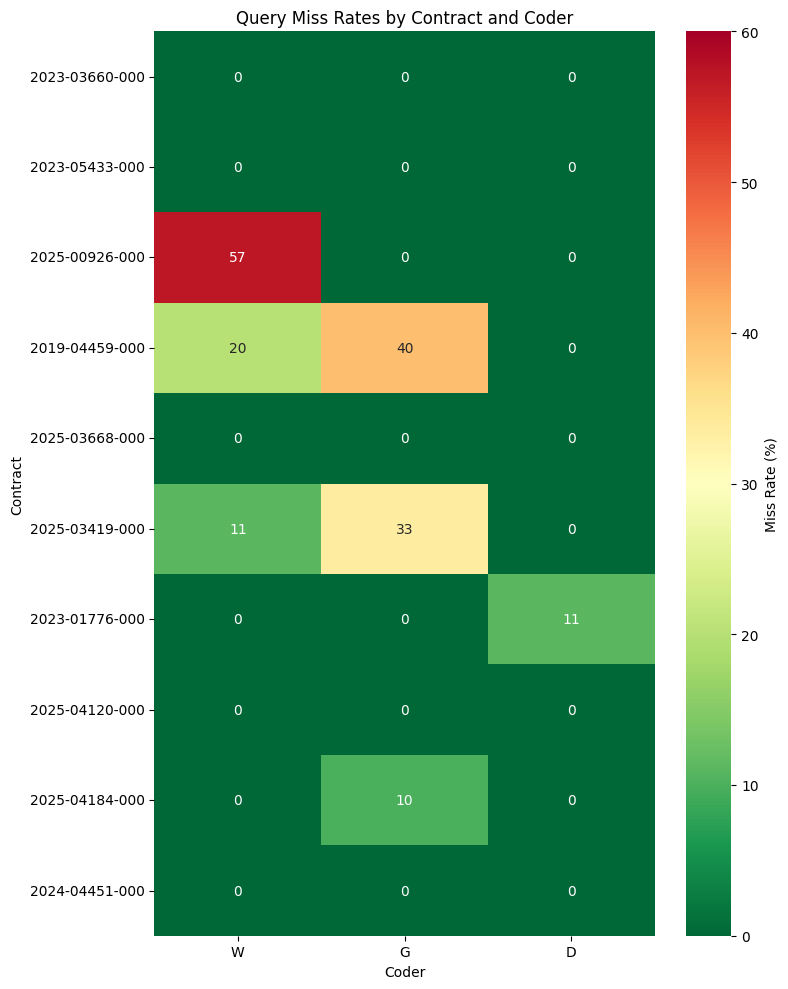

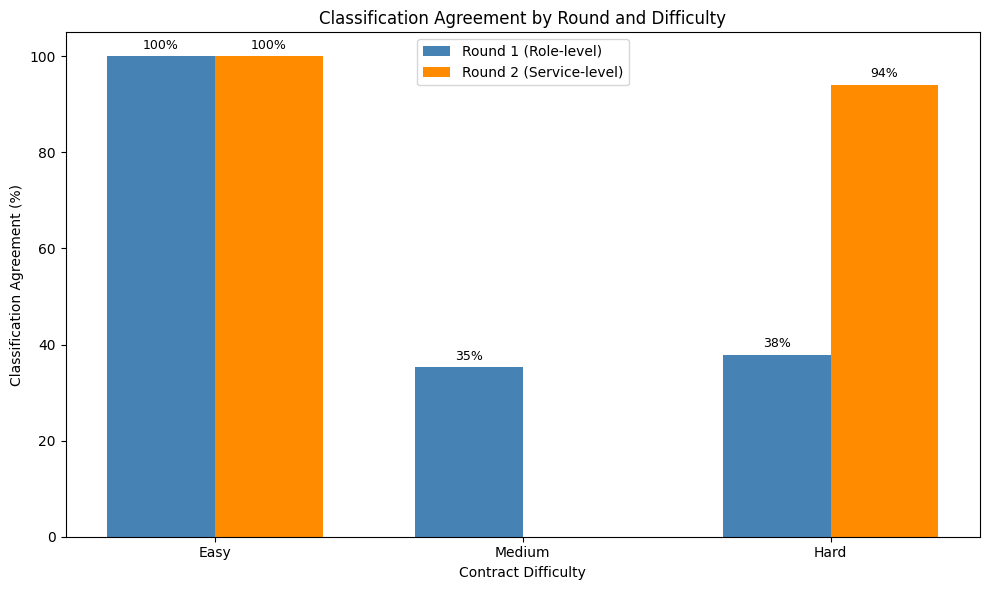

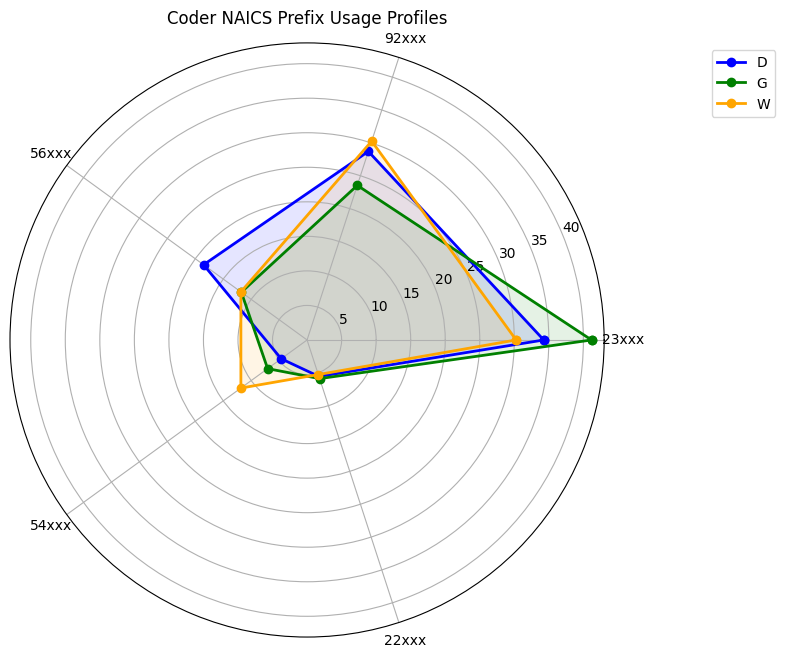

IOStream.flush timed out


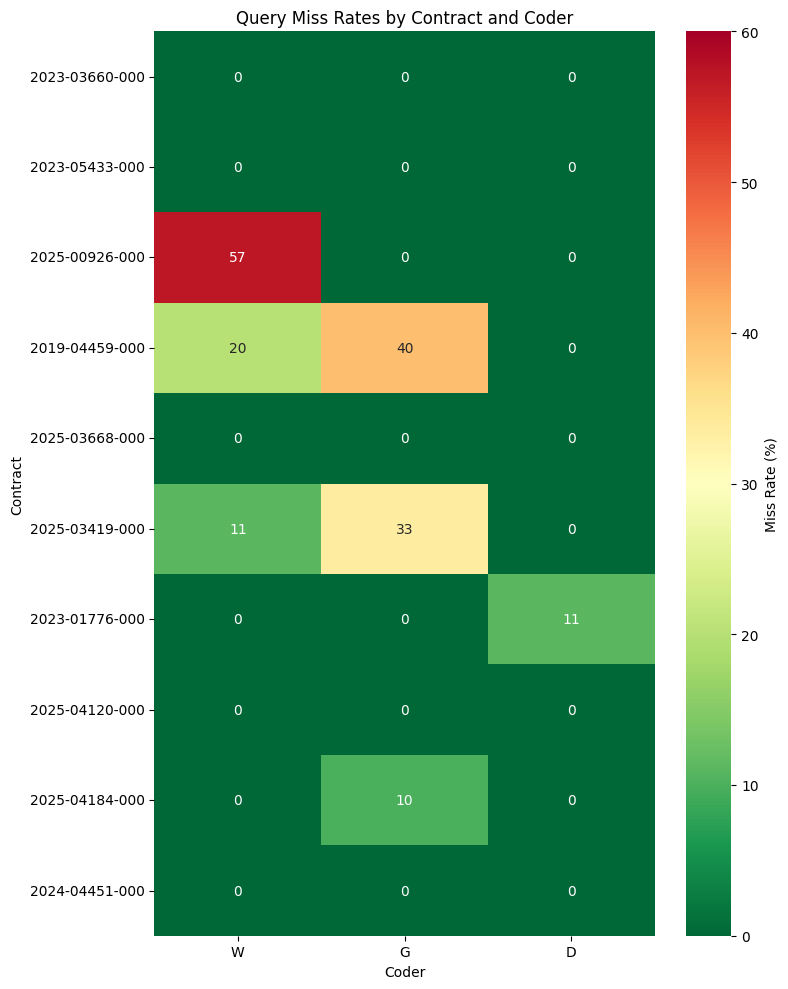

In [38]:
plot_agreement_comparison(results['results_df'], OUTPUT_DIR + 'agreement_comparison.png')
plot_coder_profiles(results['pivot'], results['top_prefixes'], OUTPUT_DIR + 'coder_profiles.png')
plot_miss_rate_heatmap(results['miss_rates_df'], OUTPUT_DIR + 'miss_rate_heatmap.png')

working above

In [ ]:
def find_similar_services(df, threshold=0.7):
    """
    Find service names that might refer to the same thing using Levenshtein distance.
    """
    services = df['Service_Raw'].unique()
    
    similar_pairs = []
    for i, s1 in enumerate(services):
        for s2 in services[i+1:]:
            # Use Levenshtein library's ratio function
            ratio = levenshtein_ratio_lib(s1.lower(), s2.lower())
            if ratio >= threshold:
                similar_pairs.append((s1, s2, ratio))
    
    return sorted(similar_pairs, key=lambda x: -x[2])

def word_overlap_ratio(s1, s2):
    """Calculate ratio based on shared words."""
    words1 = set(s1.lower().split())
    words2 = set(s2.lower().split())
    
    if not words1 or not words2:
        return 0.0
    
    intersection = words1 & words2
    union = words1 | words2
    
    return len(intersection) / len(union)

def find_service_clusters(df, threshold=0.5, use_levenshtein=False):
    """
    Cluster similar service names.
    
    Parameters:
    - use_levenshtein: If True, use Levenshtein ratio; if False, use word overlap
    """
    services = df['Service_Raw'].unique()
    
    # Build adjacency list
    similar = defaultdict(set)
    for i, s1 in enumerate(services):
        for s2 in services[i+1:]:
            if use_levenshtein:
                similarity = levenshtein_ratio_lib(s1.lower(), s2.lower())
            else:
                similarity = word_overlap_ratio(s1, s2)
            
            if similarity >= threshold:
                similar[s1].add(s2)
                similar[s2].add(s1)
    
    # Find connected components (simple DFS)
    visited = set()
    clusters = []
    
    for service in services:
        if service not in visited and service in similar:
            cluster = set()
            stack = [service]
            while stack:
                s = stack.pop()
                if s not in visited:
                    visited.add(s)
                    cluster.add(s)
                    stack.extend(similar[s] - visited)
            if len(cluster) > 1:
                clusters.append(cluster)
    
    return clusters

clusters = find_service_clusters(df, threshold=0.7, use_levenshtein=True)

In [ ]:
print("\nService Name Clusters (potentially same service):")
for i, cluster in enumerate(clusters, 1):
    print(f"\n  Cluster {i}:")
    for service in sorted(cluster):
        # Get codes assigned to this service
        codes = df[df['Service_Raw'] == service]['NAICS_Raw'].dropna().unique()
        codes_str = ', '.join(str(c) for c in codes[:3])
        print(f"    - {service} → [{codes_str}]")


Service Name Clusters (potentially same service):

  Cluster 1:
    - HVAC Mechanic → [238220]
    - Mechanic → [237310, 811111]
    - Mechanic II → [237310]

  Cluster 2:
    - Equipment operator → [237310]
    - Heavy equipment operator → [237310]
    - Motor equipment operator → [237310]
    - Senior heavy equipment operator → [237310]
    - Sewer equipment operator → [237110, 221320]
    - Solid waste equipment operator → [562111]

  Cluster 3:
    - Accounting technician → [921130]
    - Engineering → [541330]
    - Engineering  → [541330]
    - Engineering technician → [541330]
    - GIS technician → [541370, 925120]
    - Maintenance technician → [237310, 236220, 237990]
    - Parts and maintenance technician → [237310]
    - Permit technician → [925120]
    - Sign technician → [237310]

  Cluster 4:
    - Traffic and vegetation control → [237310]
    - Traffic and vegetation control mechanic → [237310]

  Cluster 5:
    - Auto maintenance → [811111]
    - Building and grounds 

**DATA DICTIONARY**
|Feature|Type|Description|
| --- | --- | --- |
|Contract|string|Contract identifier (e.g., "2023-03660-000")|
|Difficulty|string|Contract complexity: "Easy", "Medium", or "Hard"|
|Service_Raw|string|Role or service title (e.g., "Mechanic", "Police")|
|Coder|string|Coder: "W", "G", or "D"|
|Round|int|Exercise number: 1 (employees) or 2 (services)|
|NAICS_Raw|string|Assigned NAICS code, semicolon-delimited if multiple|

In [ ]:
def get_codes(naics_value):
    """
    Flexible parsing for NAICS code string to convert to set depending on number of values
    
    :param naics_value: NAICS string from a given row
    """

    if pd.isna(naics_value) or naics_value == "":
        return set()
    
    codes = str(naics_value).split(';')
    return set(code.strip() for code in codes if code.strip())

In [ ]:
df['prefix'] = df['NAICS_Raw'].astype(str).str[:2]

In [ ]:
print(df.head())

   Unnamed: 0        Contract Difficulty               Service_Raw Coder  \
0           0  2023-03660-000       Easy                  Mechanic     W   
1           1  2023-03660-000       Easy              Truck driver     W   
2           2  2023-03660-000       Easy  Heavy equipment operator     W   
3           3  2023-03660-000       Easy            Service person     G   
4           4  2023-03660-000       Easy              Truck driver     G   

   Round NAICS_Raw prefix  has_naics  is_multicode  \
0      1    237310     23       True         False   
1      1    237310     23       True         False   
2      1    237310     23       True         False   
3      1    237310     23       True         False   
4      1    237310     23       True         False   

                                lookup_key  
0                  2023-03660-000|Mechanic  
1              2023-03660-000|Truck driver  
2  2023-03660-000|Heavy equipment operator  
3            2023-03660-000|Service pe

In [ ]:
out = (
    df
    .groupby(['Coder', 'prefix'])
    .size()
    .rename('n')
    .reset_index()
    .assign(
        pct=lambda x: x['n'] / x.groupby('Coder')['n'].transform('sum') * 100,
        rank=lambda x: x.groupby('Coder')['n'].rank(method='first', ascending=False)
    )
    .query('rank <= 10')
    .pivot(index='Coder', columns='rank', values=['prefix', 'pct'])
)

out.columns = [f'{a}_{int(b)}' for a, b in out.columns]
out = out.reset_index()
out

,Coder,prefix_1,prefix_2,prefix_3,prefix_4,prefix_5,prefix_6,prefix_7,prefix_8,prefix_9,...,pct_1,pct_2,pct_3,pct_4,pct_5,pct_6,pct_7,pct_8,pct_9,pct_10
0,D,23,92,56,22,54,71,81,na,48,...,33.333333,27.927928,18.018018,5.405405,4.504505,3.603604,2.702703,2.702703,0.900901,0.900901
1,G,23,92,56,54,22,81,48,71,11,...,41.176471,23.529412,11.764706,7.058824,5.882353,3.529412,2.352941,2.352941,1.176471,1.176471
2,W,23,92,54,56,22,81,71,48,51,...,30.263158,30.263158,11.842105,11.842105,5.263158,5.263158,2.631579,1.315789,1.315789,NaN


In [ ]:
print(out)

  Coder prefix_1 prefix_2 prefix_3 prefix_4 prefix_5 prefix_6 prefix_7  \
0     D       23       92       56       22       54       71       81   
1     G       23       92       56       54       22       81       48   
2     W       23       92       54       56       22       81       71   

  prefix_8 prefix_9  ...      pct_1      pct_2      pct_3      pct_4  \
0       na       48  ...  33.333333  27.927928  18.018018   5.405405   
1       71       11  ...  41.176471  23.529412  11.764706   7.058824   
2       48       51  ...  30.263158  30.263158  11.842105  11.842105   

      pct_5     pct_6     pct_7     pct_8     pct_9    pct_10  
0  4.504505  3.603604  2.702703  2.702703  0.900901  0.900901  
1  5.882353  3.529412  2.352941  2.352941  1.176471  1.176471  
2  5.263158  5.263158  2.631579  1.315789  1.315789       NaN  

[3 rows x 21 columns]


In [ ]:
prefix_cols = [c for c in out.columns if c.startswith('prefix_')]

coder_prefix_sets = (
    out
    .set_index('Coder')[prefix_cols]
    .apply(lambda row: set(row.dropna()), axis=1)
)

In [ ]:
shared_prefixes = set.intersection(*coder_prefix_sets)

shared_prefixes

{'22', '23', '48', '54', '56', '71', '81', '92'}

In [ ]:
shared_prefix_means = {}

for p in shared_prefixes:
    pct_vals = []
    for i in range(1, 11):  # adjust max rank if needed
        mask = out[f'prefix_{i}'] == p
        pct_vals.extend(out.loc[mask, f'pct_{i}'].tolist())
    shared_prefix_means[p] = sum(pct_vals) / len(pct_vals)

In [ ]:
top_shared = (
    pd.Series(shared_prefix_means)
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

top_shared

['23', '92', '56', '54', '22']

In [ ]:
rows = []

for _, row in out.iterrows():
    coder = row['Coder']
    record = {'Coder': coder}

    for p in top_shared:
        for i in range(1, 11):
            if row[f'prefix_{i}'] == p:
                record[p] = row[f'pct_{i}']
                break
        else:
            record[p] = 0.0  # prefix not used by this coder

    rows.append(record)

comparison = pd.DataFrame(rows)

In [ ]:
comparison

,Coder,23,92,56,54,22
0,D,33.333333,27.927928,18.018018,4.504505,5.405405
1,G,41.176471,23.529412,11.764706,7.058824,5.882353
2,W,30.263158,30.263158,11.842105,11.842105,5.263158


In [ ]:
r2 = df[df['Round'] == 2]

In [ ]:
df.columns

Index(['Unnamed: 0', 'Contract', 'Difficulty', 'Service_Raw', 'Coder', 'Round',
       'NAICS_Raw', 'prefix', 'has_naics', 'is_multicode', 'lookup_key'],
      dtype='object')

In [ ]:
# ---------------------------
# 1️⃣ Build pairwise disagreement per contract
# ---------------------------

# Group coder → NAICS sets, keeping Round & Difficulty
sets = (
    df
    .groupby(['Contract', 'Round', 'Difficulty', 'Coder'])['NAICS_Raw']
    .apply(lambda x: set(x.dropna()))
    .reset_index()
)

rows = []

for (contract, round_, difficulty), g in sets.groupby(['Contract', 'Round', 'Difficulty']):
    coder_sets = dict(zip(g['Coder'], g['NAICS_Raw']))
    
    # Compute pairwise Jaccard distances
    dists = [
        1 - len(coder_sets[c1] & coder_sets[c2]) / len(coder_sets[c1] | coder_sets[c2])
        for c1, c2 in combinations(coder_sets, 2)
    ]
    
    rows.append({
        'Contract': contract,
        'Round': round_,
        'Difficulty': difficulty,
        'mean_disagreement': sum(dists) / len(dists) if dists else 0.0,
        'max_disagreement': max(dists) if dists else 0.0,
        'n_coders': len(coder_sets)
    })

disagreement_by_contract = pd.DataFrame(rows)

In [ ]:
# ---------------------------
# 2️⃣ Aggregate by Round
# ---------------------------

disagreement_by_round = (
    disagreement_by_contract
    .groupby('Round')
    .agg({
        'mean_disagreement': 'mean',
        'max_disagreement': 'mean',
        'n_coders': 'mean'
    })
    .reset_index()
)

# ---------------------------
# 3️⃣ Aggregate by Difficulty
# ---------------------------

disagreement_by_difficulty = (
    disagreement_by_contract
    .groupby('Difficulty')
    .agg({
        'mean_disagreement': 'mean',
        'max_disagreement': 'mean',
        'n_coders': 'mean'
    })
    .reset_index()
)


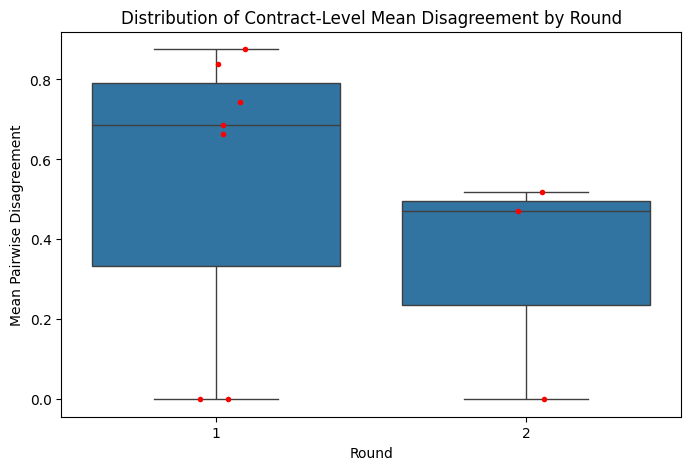

In [ ]:
# ---------------------------
# 4️⃣ Visualization: mean disagreement by Round
# ---------------------------

plt.figure(figsize=(8,5))
sns.boxplot(data=disagreement_by_contract, x='Round', y='mean_disagreement')
sns.stripplot(data=disagreement_by_contract, x='Round', y='mean_disagreement', color='red', size=4, jitter=True)
plt.title("Distribution of Contract-Level Mean Disagreement by Round")
plt.ylabel("Mean Pairwise Disagreement")
plt.show()

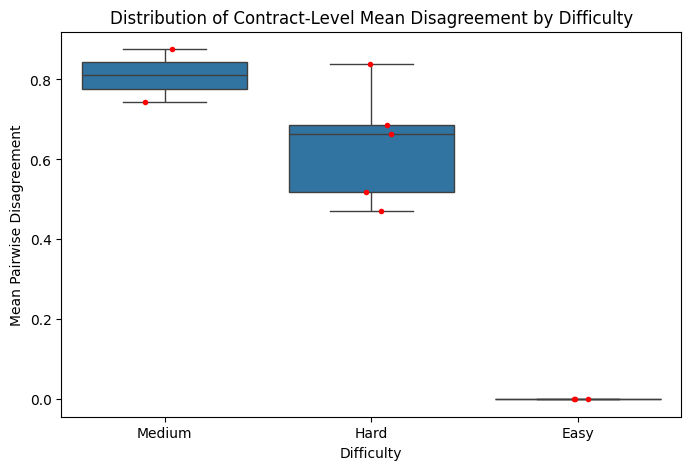

In [ ]:
# ---------------------------
# 5️⃣ Visualization: mean disagreement by Difficulty
# ---------------------------

plt.figure(figsize=(8,5))
sns.boxplot(data=disagreement_by_contract, x='Difficulty', y='mean_disagreement')
sns.stripplot(data=disagreement_by_contract, x='Difficulty', y='mean_disagreement', color='red', size=4, jitter=True)
plt.title("Distribution of Contract-Level Mean Disagreement by Difficulty")
plt.ylabel("Mean Pairwise Disagreement")
plt.show()

In [ ]:

# ---------------------------
# 6️⃣ Quick Analysis
# ---------------------------

print("Mean disagreement by Round:")
print(disagreement_by_round)

print("\nMean disagreement by Difficulty:")
print(disagreement_by_difficulty)

# Optional: contracts with highest disagreement
top_disagreements = disagreement_by_contract.sort_values('mean_disagreement', ascending=False).head(10)
print("\nTop 10 most disagreed contracts:")
print(top_disagreements[['Contract', 'Round', 'Difficulty', 'mean_disagreement', 'max_disagreement']])

Mean disagreement by Round:
   Round  mean_disagreement  max_disagreement  n_coders
0      1           0.544224          0.612745       3.0
1      2           0.330364          0.380952       3.0

Mean disagreement by Difficulty:
  Difficulty  mean_disagreement  max_disagreement  n_coders
0       Easy           0.000000          0.000000       3.0
1       Hard           0.636117          0.731513       3.0
2     Medium           0.810037          0.887255       3.0

Top 10 most disagreed contracts:
         Contract  Round Difficulty  mean_disagreement  max_disagreement
5  2025-00926-000      1     Medium           0.875630          0.941176
6  2025-03419-000      1       Hard           0.838889          1.000000
0  2019-04459-000      1     Medium           0.744444          0.833333
7  2025-03668-000      1       Hard           0.685897          0.750000
1  2023-01776-000      1       Hard           0.664706          0.764706
4  2024-04451-000      2       Hard           0.519414    

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    272 non-null    int64 
 1   Contract      272 non-null    object
 2   Difficulty    272 non-null    object
 3   Service_Raw   272 non-null    object
 4   Coder         272 non-null    object
 5   Round         272 non-null    int64 
 6   NAICS_Raw     269 non-null    object
 7   prefix        272 non-null    object
 8   has_naics     272 non-null    bool  
 9   is_multicode  272 non-null    bool  
 10  lookup_key    272 non-null    object
dtypes: bool(2), int64(2), object(7)
memory usage: 19.8+ KB


In [ ]:
print(df.head())

   Unnamed: 0        Contract Difficulty               Service_Raw Coder  \
0           0  2023-03660-000       Easy                  Mechanic     W   
1           1  2023-03660-000       Easy              Truck driver     W   
2           2  2023-03660-000       Easy  Heavy equipment operator     W   
3           3  2023-03660-000       Easy            Service person     G   
4           4  2023-03660-000       Easy              Truck driver     G   

   Round NAICS_Raw prefix  has_naics  is_multicode  \
0      1    237310     23       True         False   
1      1    237310     23       True         False   
2      1    237310     23       True         False   
3      1    237310     23       True         False   
4      1    237310     23       True         False   

                                lookup_key  
0                  2023-03660-000|Mechanic  
1              2023-03660-000|Truck driver  
2  2023-03660-000|Heavy equipment operator  
3            2023-03660-000|Service pe

In [ ]:
df['Contract'] = df['Contract'].str.strip()

# Helper functions
def get_prefix(code):
    """Extract 2-digit code family"""
    if pd.isna(code) or str(code).strip() == '':
        return None
    return str(code).split(';')[0][:2]

def get_codes_set(val):
    """Parse semicolon-separated codes into set"""
    if pd.isna(val) or str(val).strip() == '':
        return set()
    return set(str(val).split(';'))

def check_agree(codes):
    """Check if all codes in list are identical"""
    codes = [str(c) for c in codes if pd.notna(c)]
    return len(set(codes)) == 1 if len(codes) >= 2 else None

df['prefix'] = df['NAICS_Raw'].apply(get_prefix)


In [ ]:
# Group by Contract + Service to find overlaps
service_groups = df.groupby(['Contract', 'Service_Raw']).agg({
    'Coder': list,
    'NAICS_Raw': list
}).reset_index()

service_groups['num_coders'] = service_groups['Coder'].apply(len)

# CRITICAL FIX: Only keep services with 2+ coders BEFORE checking agreement
overlaps = service_groups[service_groups['num_coders'] >= 2].copy()

# Calculate agreement for each overlap
overlaps['agreed'] = overlaps['NAICS_Raw'].apply(check_agree)

# CRITICAL FIX: Remove rows where agreement couldn't be determined
overlaps_valid = overlaps[overlaps['agreed'].notna()].copy()

# Now aggregate by service name
service_stats = overlaps_valid.groupby('Service_Raw').agg({
    'agreed': ['sum', 'count']
}).reset_index()
service_stats.columns = ['Service_Raw', 'agree_count', 'total_count']

# CRITICAL FIX: Only calculate rate where total_count > 0
service_stats['agreement_rate'] = np.where(
    service_stats['total_count'] > 0,
    service_stats['agree_count'] / service_stats['total_count'],
    np.nan
)

# Services that always agree (100%)
always_agree = service_stats[service_stats['agreement_rate'] == 1.0]
print("\n=== ALWAYS AGREE (Handbook Examples) ===")
for _, row in always_agree.sort_values('total_count', ascending=False).head(15).iterrows():
    # Get the code they agreed on
    agreed_rows = overlaps_valid[
        (overlaps_valid['Service_Raw'] == row['Service_Raw']) & 
        (overlaps_valid['agreed'] == True)
    ]
    if len(agreed_rows) > 0:
        codes = agreed_rows['NAICS_Raw'].iloc[0]
        code = [c for c in codes if pd.notna(c) and str(c).strip()][0]
        print(f"  {row['Service_Raw']:40} → {code} (n={int(row['total_count'])})")

# Services that always disagree (0%)
always_disagree = service_stats[service_stats['agreement_rate'] == 0.0]
print("\n=== ALWAYS DISAGREE (Need Guidance) ===")
for _, row in always_disagree.iterrows():
    # Show the conflicting codes
    disagree_rows = overlaps_valid[overlaps_valid['Service_Raw'] == row['Service_Raw']]
    if len(disagree_rows) > 0:
        all_codes = set()
        for codes in disagree_rows['NAICS_Raw']:
            all_codes.update([str(c) for c in codes if pd.notna(c)])
        print(f"  {row['Service_Raw']:40} → Codes: {sorted(all_codes)}")

# Services with partial agreement
partial = service_stats[
    (service_stats['agreement_rate'] > 0) & 
    (service_stats['agreement_rate'] < 1)
]
print(f"\n=== PARTIAL AGREEMENT ({len(partial)} services) ===")
for _, row in partial.sort_values('agreement_rate').head(10).iterrows():
    print(f"  {row['Service_Raw']:40} → {row['agreement_rate']*100:.0f}% agreement")


=== ALWAYS AGREE (Handbook Examples) ===
  Truck driver                             → 237310 (n=3)
  Water supply                             → 221310 (n=2)
  Heavy equipment operator                 → 237310 (n=2)
  Highway and road maintenance             → 237310 (n=2)
  Public finance                           → 921130 (n=1)
  Urban planning and development           → 925120 (n=1)
  Traffic control crew                     → 237310 (n=1)
  Tax assessor                             → 921130 (n=1)
  Surveying                                → 541370 (n=1)
  Sign technician                          → 237310 (n=1)
  Sewer collection operations              → 221320 (n=1)
  Service person                           → 237310 (n=1)
  Road related                             → 237310 (n=1)
  Road maintenance                         → 237310 (n=1)
  Road inspector                           → 237310 (n=1)

=== ALWAYS DISAGREE (Need Guidance) ===
  Administrative support                   → Co

**QUERY PERFORMANCE SIMULATION**

PURPOSE: Directly answer "If different coders code the same contract, 
         how much does search performance actually vary?"

APPROACH:
1. Define realistic search queries (NAICS codes researchers would search for)
2. For each contract, compute which queries would "hit" each coder's code set
3. Compare single-coder recall vs. union recall

In [ ]:
def get_codes_set(naics_str):
    """Parse NAICS codes from semicolon-delimited string into a set."""
    if pd.isna(naics_str) or naics_str == '':
        return set()
    return set(str(naics_str).strip().split(';'))

def get_prefixes_set(codes_set):
    """Extract 2-digit prefixes from a set of NAICS codes."""
    return set(str(c)[:2] for c in codes_set if len(str(c)) >= 2)

def query_matches(code_set, query_codes):
    """
    Check if a code set satisfies a query.
    Returns True if ANY code in code_set matches ANY query code (exact or prefix).
    """
    for code in code_set:
        code_str = str(code).strip()
        for query in query_codes:
            query_str = str(query).strip()
            # Exact match or prefix match
            if code_str == query_str or code_str.startswith(query_str):
                return True
    return False

In [ ]:
QUERY_SCENARIOS = {
    # Query name: (list of NAICS codes OR prefixes that satisfy the query)
    'road_maintenance': ['237310', '237'],  # Highway/road construction
    'police_services': ['922120', '922'],   # Police protection
    'water_utilities': ['221310', '221'],   # Water supply
    'sewer_services': ['221320', '237110', '221', '237'],  # Sewer
    'fire_protection': ['922160', '922'],   # Fire
    'parks_recreation': ['712190', '713940', '561730', '712', '713', '561'],
    'building_maintenance': ['236220', '561210', '236', '561'],
    'administrative': ['921130', '921190', '921'],  # Public admin
    'professional_services': ['541330', '541370', '541512', '541'],
    'corrections': ['922140', '922'],  # Correctional institutions
}

In [ ]:
def query_matches(code_set, query_codes):
    """
    Check if a code set satisfies a query.
    Returns True if ANY code in code_set matches ANY query code (exact or prefix).
    """
    for code in code_set:
        code_str = str(code).strip()
        for query in query_codes:
            query_str = str(query).strip()
            # Exact match or prefix match
            if code_str == query_str or code_str.startswith(query_str):
                return True
    return False

In [ ]:
def simulate_query_performance(df, contract_id):
    """
    Simulate query performance for a single contract.
    
    Returns dict with:
    - Per-coder query hits
    - Union query hits
    - Recall metrics
    """
    df_contract = df[df['Contract'] == contract_id]
    
    # Build code sets for each coder
    codes_by_coder = {}
    for coder in df_contract['Coder'].unique():
        coder_df = df_contract[df_contract['Coder'] == coder]
        codes = set()
        for naics in coder_df['NAICS_Raw'].dropna():
            codes.update(get_codes_set(naics))
        codes_by_coder[coder] = codes
    
    # Union of all coders
    union_codes = set.union(*codes_by_coder.values()) if codes_by_coder else set()
    
    # Simulate each query
    results = {
        'contract': contract_id,
        'difficulty': df_contract['Difficulty'].iloc[0],
        'coder_hits': {coder: [] for coder in codes_by_coder},
        'union_hits': [],
        'queries_tested': []
    }
    
    for query_name, query_codes in QUERY_SCENARIOS.items():
        results['queries_tested'].append(query_name)
        
        # Check union (ground truth for this contract)
        union_hit = query_matches(union_codes, query_codes)
        results['union_hits'].append(union_hit)
        
        # Check each coder
        for coder, codes in codes_by_coder.items():
            coder_hit = query_matches(codes, query_codes)
            results['coder_hits'][coder].append(coder_hit)
    
    return results

# Run simulation for all contracts
print("\nQuery Performance by Contract:")
print("-" * 80)

simulation_results = []
for contract in df['Contract'].unique():
    result = simulate_query_performance(df, contract)
    simulation_results.append(result)
    
    # Calculate metrics
    union_recall = sum(result['union_hits'])
    coder_recalls = {c: sum(hits) for c, hits in result['coder_hits'].items()}
    
    if union_recall > 0:  # Only show contracts with at least one query hit
        print(f"\n{contract} ({result['difficulty']}):")
        print(f"  Union hits: {union_recall}/{len(QUERY_SCENARIOS)} queries")
        for coder, recall in sorted(coder_recalls.items()):
            miss_rate = (union_recall - recall) / union_recall * 100 if union_recall > 0 else 0
            print(f"  {coder} hits: {recall}/{len(QUERY_SCENARIOS)} (misses {miss_rate:.0f}% of union)")



Query Performance by Contract:
--------------------------------------------------------------------------------

2023-03660-000 (Easy):
  Union hits: 2/10 queries
  D hits: 2/10 (misses 0% of union)
  G hits: 2/10 (misses 0% of union)
  W hits: 2/10 (misses 0% of union)

2023-05433-000 (Easy):
  Union hits: 2/10 queries
  D hits: 2/10 (misses 0% of union)
  G hits: 2/10 (misses 0% of union)
  W hits: 2/10 (misses 0% of union)

2025-00926-000 (Medium):
  Union hits: 7/10 queries
  D hits: 7/10 (misses 0% of union)
  G hits: 7/10 (misses 0% of union)
  W hits: 3/10 (misses 57% of union)

2019-04459-000 (Medium):
  Union hits: 5/10 queries
  D hits: 5/10 (misses 0% of union)
  G hits: 3/10 (misses 40% of union)
  W hits: 4/10 (misses 20% of union)

2025-03668-000 (Hard):
  Union hits: 9/10 queries
  D hits: 9/10 (misses 0% of union)
  G hits: 9/10 (misses 0% of union)
  W hits: 9/10 (misses 0% of union)

2025-03419-000 (Hard):
  Union hits: 9/10 queries
  D hits: 9/10 (misses 0% of union

In [ ]:
print("\n" + "-" * 80)
print("AGGREGATE QUERY PERFORMANCE:")

# Calculate per-coder miss rates across all contracts
all_coder_misses = defaultdict(list)
all_union_hits = 0
all_coder_hits = defaultdict(int)

for result in simulation_results:
    union_hits = sum(result['union_hits'])
    all_union_hits += union_hits
    
    for coder, hits in result['coder_hits'].items():
        coder_total = sum(hits)
        all_coder_hits[coder] += coder_total
        if union_hits > 0:
            miss_rate = (union_hits - coder_total) / union_hits
            all_coder_misses[coder].append(miss_rate)

print(f"\nTotal union query hits: {all_union_hits}")
for coder in sorted(all_coder_hits.keys()):
    avg_miss = np.mean(all_coder_misses[coder]) * 100
    print(f"  {coder}: {all_coder_hits[coder]} hits, avg miss rate: {avg_miss:.1f}%")

# Key insight for decision-making
print("\n>>> KEY INSIGHT:")
print("    If using single-coder production model, expect to miss")
print(f"   approximately {np.mean([np.mean(m) for m in all_coder_misses.values()])*100:.0f}% of")
print("    query-relevant services that multi-coding would capture.")


--------------------------------------------------------------------------------
AGGREGATE QUERY PERFORMANCE:

Total union query hits: 61
  D: 60 hits, avg miss rate: 1.1%
  G: 55 hits, avg miss rate: 8.3%
  W: 55 hits, avg miss rate: 8.8%

>>> KEY INSIGHT:
    If using single-coder production model, expect to miss
   approximately 6% of
    query-relevant services that multi-coding would capture.


**JACCARD SIMILARITY ANALYSIS**

PURPOSE: Quantify code set overlap between coders more precisely than 
         simple agreement rates.

Jaccard Similarity = |A ∩ B| / |A ∪ B|
- 1.0 = identical code sets
- 0.0 = completely disjoint code sets

In [ ]:
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets."""
    if not set1 and not set2:
        return 1.0  # Both empty = perfect agreement
    if not set1 or not set2:
        return 0.0  # One empty = no overlap
    
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

def analyze_jaccard_by_contract(df):
    """Calculate pairwise Jaccard similarities for each contract."""
    results = []
    
    for contract in df['Contract'].unique():
        df_c = df[df['Contract'] == contract]
        difficulty = df_c['Difficulty'].iloc[0]
        round_num = df_c['Round'].iloc[0]
        
        # Get code sets by coder
        codes_by_coder = {}
        for coder in df_c['Coder'].unique():
            coder_df = df_c[df_c['Coder'] == coder]
            codes = set()
            for naics in coder_df['NAICS_Raw'].dropna():
                codes.update(get_codes_set(naics))
            codes_by_coder[coder] = codes
        
        # Calculate pairwise similarities
        similarities = []
        pairs = []
        for c1, c2 in combinations(sorted(codes_by_coder.keys()), 2):
            sim = jaccard_similarity(codes_by_coder[c1], codes_by_coder[c2])
            similarities.append(sim)
            pairs.append((c1, c2, sim))
        
        results.append({
            'Contract': contract,
            'Difficulty': difficulty,
            'Round': round_num,
            'mean_jaccard': np.mean(similarities) if similarities else None,
            'min_jaccard': min(similarities) if similarities else None,
            'max_jaccard': max(similarities) if similarities else None,
            'pairs': pairs
        })
    
    return pd.DataFrame(results)

jaccard_df = analyze_jaccard_by_contract(df)

In [ ]:
print("\nJaccard Similarity by Contract:")
print(jaccard_df[['Contract', 'Difficulty', 'Round', 'mean_jaccard', 'min_jaccard']].to_string())

print("\nMean Jaccard by Difficulty:")
print(jaccard_df.groupby('Difficulty')['mean_jaccard'].agg(['mean', 'std']).round(3))

print("\nMean Jaccard by Round:")
print(jaccard_df.groupby('Round')['mean_jaccard'].agg(['mean', 'std']).round(3))

# Detailed pairwise breakdown
print("\nPairwise Jaccard Similarities (all contracts):")
all_pairs = defaultdict(list)
for _, row in jaccard_df.iterrows():
    if row['pairs']:
        for c1, c2, sim in row['pairs']:
            all_pairs[(c1, c2)].append(sim)

for pair, sims in sorted(all_pairs.items()):
    print(f"  {pair[0]}-{pair[1]}: mean={np.mean(sims):.3f}, std={np.std(sims):.3f}")



Jaccard Similarity by Contract:
         Contract Difficulty  Round  mean_jaccard  min_jaccard
0  2023-03660-000       Easy      1      1.000000     1.000000
1  2023-05433-000       Easy      1      1.000000     1.000000
2  2025-00926-000     Medium      1      0.156614     0.055556
3  2019-04459-000     Medium      1      0.255556     0.166667
4  2025-03668-000       Hard      1      0.332723     0.307692
5  2025-03419-000       Hard      1      0.136752     0.000000
6  2023-01776-000       Hard      1      0.335294     0.235294
7  2025-04120-000       Easy      2      1.000000     1.000000
8  2025-04184-000       Hard      2      0.598039     0.500000
9  2024-04451-000       Hard      2      0.483183     0.384615

Mean Jaccard by Difficulty:
             mean    std
Difficulty              
Easy        1.000  0.000
Hard        0.377  0.174
Medium      0.206  0.070

Mean Jaccard by Round:
        mean    std
Round              
1      0.460  0.377
2      0.694  0.271

Pairwise Jaccar

**CROSS-CONTRACT SERVICE --> NAICS CONSISTENCY**

PURPOSE: Check if the same service gets the same NAICS code across 
         different contracts.

APPROACH:
1. Group by Service_Raw across ALL contracts
2. Check code variance for each service
3. Flag services with inconsistent coding

In [ ]:
def analyze_cross_contract_consistency(df):
    """
    Check if services are coded consistently across contracts.
    """
    # Normalize service names (lowercase, strip whitespace)
    df_norm = df.copy()
    df_norm['Service_Normalized'] = df_norm['Service_Raw'].str.lower().str.strip()
    
    # Group by normalized service name
    service_codes = df_norm.groupby('Service_Normalized').agg({
        'NAICS_Raw': lambda x: list(x.dropna()),
        'Contract': lambda x: list(x.unique()),
        'Coder': lambda x: list(x)
    }).reset_index()
    
    # Only analyze services appearing in 2+ contracts
    service_codes['num_contracts'] = service_codes['Contract'].apply(len)
    multi_contract = service_codes[service_codes['num_contracts'] >= 2].copy()
    
    results = []
    for _, row in multi_contract.iterrows():
        codes = [str(c).split(';')[0] for c in row['NAICS_Raw'] if c]  # Take first code if multi
        unique_codes = set(codes)
        prefixes = set(c[:2] for c in unique_codes if len(c) >= 2)
        
        results.append({
            'service': row['Service_Normalized'],
            'num_contracts': row['num_contracts'],
            'unique_codes': len(unique_codes),
            'codes': sorted(unique_codes),
            'same_prefix': len(prefixes) == 1,
            'prefixes': sorted(prefixes)
        })
    
    return pd.DataFrame(results)

consistency_df = analyze_cross_contract_consistency(df)

In [ ]:

# Services with consistent coding
consistent = consistency_df[consistency_df['unique_codes'] == 1]
print(f"\nConsistently coded services: {len(consistent)}/{len(consistency_df)}")
print("\nExamples of consistent services:")
for _, row in consistent.head(10).iterrows():
    print(f"  {row['service']:40} → {row['codes'][0]} (in {row['num_contracts']} contracts)")

# Services with inconsistent coding
inconsistent = consistency_df[consistency_df['unique_codes'] > 1]
print(f"\nInconsistently coded services: {len(inconsistent)}/{len(consistency_df)}")
print("\nInconsistent services (NEED ATTENTION):")
for _, row in inconsistent.sort_values('unique_codes', ascending=False).iterrows():
    prefix_note = "SAME PREFIX" if row['same_prefix'] else "DIFF PREFIX"
    print(f"  {row['service']:40} → {row['codes']} [{prefix_note}]")



Consistently coded services: 10/23

Examples of consistent services:
  county attorney                          → 922130 (in 2 contracts)
  engineering                              → 541330 (in 2 contracts)
  heavy equipment operator                 → 237310 (in 5 contracts)
  highway and road maintenance             → 237310 (in 2 contracts)
  road maintenance                         → 237310 (in 3 contracts)
  senior heavy equipment operator          → 237310 (in 2 contracts)
  sewage treatment                         → 221320 (in 2 contracts)
  tax assessor                             → 921130 (in 2 contracts)
  truck driver                             → 237310 (in 4 contracts)
  water supply                             → 221310 (in 2 contracts)

Inconsistently coded services: 13/23

Inconsistent services (NEED ATTENTION):
  maintenance technician                   → ['236220', '237310', '237990', '561210'] [DIFF PREFIX]
  administrative support                   → ['561110', '9211

**PREFIX CONFUSION MATRIX**

PURPOSE: Identify which NAICS code families are systematically confused.

APPROACH:
1. For each disagreement, record the prefix pair
2. Build a confusion matrix showing which prefixes are confused with which

In [ ]:
def build_prefix_confusion_matrix(df):
    """
    Build a matrix showing which NAICS prefixes are confused with each other.
    """
    # Find disagreements
    service_groups = df.groupby(['Contract', 'Service_Raw']).agg({
        'Coder': list,
        'NAICS_Raw': list
    }).reset_index()
    
    overlaps = service_groups[service_groups['Coder'].apply(len) >= 2]
    
    confusion_counts = defaultdict(int)
    
    for _, row in overlaps.iterrows():
        codes = [str(c).split(';')[0] for c in row['NAICS_Raw'] if pd.notna(c) and str(c).strip()]
        prefixes = [c[:2] for c in codes if len(c) >= 2]
        unique_prefixes = set(prefixes)
        
        if len(unique_prefixes) > 1:
            # Record all prefix pairs in disagreement
            for p1, p2 in combinations(sorted(unique_prefixes), 2):
                confusion_counts[(p1, p2)] += 1
    
    return confusion_counts

confusion = build_prefix_confusion_matrix(df)

print("\nPrefix Confusion Pairs (sorted by frequency):")
for (p1, p2), count in sorted(confusion.items(), key=lambda x: -x[1]):
    # Add descriptions for common prefixes
    prefix_names = {
        '23': 'Construction',
        '92': 'Public Admin',
        '56': 'Admin/Waste',
        '54': 'Professional',
        '22': 'Utilities',
        '81': 'Repair/Maint',
        '71': 'Recreation',
        '48': 'Transport',
        '51': 'Information',
        '61': 'Education',
        '62': 'Healthcare'
    }
    name1 = prefix_names.get(p1, '?')
    name2 = prefix_names.get(p2, '?')
    print(f"  {p1} ({name1}) ↔ {p2} ({name2}): {count} disagreements")



Prefix Confusion Pairs (sorted by frequency):
  23 (Construction) ↔ 56 (Admin/Waste): 5 disagreements
  23 (Construction) ↔ 48 (Transport): 2 disagreements
  22 (Utilities) ↔ 23 (Construction): 2 disagreements
  54 (Professional) ↔ 92 (Public Admin): 2 disagreements
  56 (Admin/Waste) ↔ 92 (Public Admin): 2 disagreements
  71 (Recreation) ↔ 92 (Public Admin): 1 disagreements
  23 (Construction) ↔ 81 (Repair/Maint): 1 disagreements
  81 (Repair/Maint) ↔ 92 (Public Admin): 1 disagreements
  23 (Construction) ↔ 54 (Professional): 1 disagreements


In [ ]:
all_prefixes = sorted(set(p for pair in confusion.keys() for p in pair))
matrix = pd.DataFrame(0, index=all_prefixes, columns=all_prefixes)
for (p1, p2), count in confusion.items():
    matrix.loc[p1, p2] = count
    matrix.loc[p2, p1] = count

print("\nConfusion Matrix (non-zero cells only):")
print(matrix[matrix.sum(axis=1) > 0].loc[:, matrix.sum(axis=0) > 0])


Confusion Matrix (non-zero cells only):
    22  23  48  54  56  71  81  92
22   0   2   0   0   0   0   0   0
23   2   0   2   1   5   0   1   0
48   0   2   0   0   0   0   0   0
54   0   1   0   0   0   0   0   2
56   0   5   0   0   0   0   0   2
71   0   0   0   0   0   0   0   1
81   0   1   0   0   0   0   0   1
92   0   0   0   2   2   1   1   0


**POST-CLUSTERING ANALYSIS**

What to do with the fuzzy matching clusters:

1. CLEAN UP FALSE CLUSTERS (manual review)
2. RE-ANALYZE AGREEMENT with normalized service names
3. IDENTIFY TRUE DISAGREEMENTS vs. naming variations
4. UPDATE YOUR METRICS with the corrected data

This matters because your current analysis overcounts disagreements
when coders used different names for the same service.
"""


Not all clusters are valid! Review each one:

GOOD CLUSTERS (same service, different names):
- Cluster 2: Equipment operators are all the same functional role
- Cluster 13: Groundskeeper = Groundskeeping
- Cluster 16: Fire prevention = Fire protection
- Cluster 17: Sewage related = Sewage treatment

BAD CLUSTERS (different services that happen to share words):
- Cluster 3: "Engineering technician" ≠ "Maintenance technician" ≠ "GIS technician"
- Cluster 5: Way too broad - "Building maintenance" ≠ "Golf course maintenance"
- Cluster 9: "County assessor" ≠ "Land surveyor" (different jobs)
- Cluster 10: "Jail administration" ≠ "Network administration" (!)
- Cluster 15: "Receptionist" ≠ "Recreation" (!!)


In [ ]:

# Define VALID equivalence mappings (after manual review)
# Format: 'canonical_name': ['variant1', 'variant2', ...]
SERVICE_EQUIVALENCES = {
    # Equipment operators (same role, different seniority/specificity)
    'Equipment operator': [
        'Equipment operator',
        'Heavy equipment operator', 
        'Motor equipment operator',
        'Senior heavy equipment operator',
    ],

    
    # Mechanic variations (same role)
    'Mechanic': [
        'Mechanic',
        'Mechanic II',
    ],
    
    # Groundskeeper variations
    'Groundskeeper': [
        'Groundskeeper',
        'Groundskeeping',
    ],
    
    # Fire services (same function)
    'Fire protection': [
        'Fire protection',
        'Fire prevention',
    ],
    
    # Sewage (same function)
    'Sewage treatment': [
        'Sewage treatment',
        'Sewage related',
    ],
    
    # Road maintenance variations
    'Road maintenance': [
        'Road maintenance',
        'Highway and road maintenance',
        'Road related',
    ],
    
    # Traffic control variations
    'Traffic control': [
        'Traffic control crew',
        'Traffic maintenance',
        'Traffic and vegetation control',
        'Traffic and vegetation control mechanic',
    ],
    
    # Truck driver variations
    'Truck driver': [
        'Truck driver',
        'Truck driver apprentice',
    ],
    
    # Building maintenance (careful - only truly equivalent ones)
    'Building maintenance': [
        'Building maintenance',
        'Building and grounds maintenance',
    ],
    
    # Parks (careful distinctions)
    'Parks maintenance': [
        'Park maintenance',
        'Parks and landscaping',
    ],
    
    # Sewer operations (same function)
    'Sewer maintenance': [
        'Sewer maintenance',
        'Sewer repair',
        'Sewer line maintenance',
    ],
    
    # Recreation programs
    'Recreation': [
        'Recreation',
        'Recreation programs',
        'Recreation and lifeguards',
    ],
    
    # Engineering (same function)
    'Engineering': [
        'Engineering',
        'Engineering ',  # with trailing space
    ],
    
    # Surveying
    'Surveying': [
        'Surveying',
        'Land surveyor',
        'County surveyor',
    ],
}

# Create reverse mapping: variant -> canonical
def build_normalization_map(equivalences):
    """Build mapping from variant names to canonical names."""
    norm_map = {}
    for canonical, variants in equivalences.items():
        for variant in variants:
            norm_map[variant.lower().strip()] = canonical
    return norm_map

NORM_MAP = build_normalization_map(SERVICE_EQUIVALENCES)

def normalize_service(service_name):
    """Normalize a service name to its canonical form."""
    key = service_name.lower().strip()
    return NORM_MAP.get(key, service_name)  # Return original if not in map

print("="*70)
print("RE-ANALYSIS WITH NORMALIZED SERVICE NAMES")
print("="*70)

# Add normalized column
df['Service_Normalized'] = df['Service_Raw'].apply(normalize_service)

# Count how many services were normalized
original_unique = df['Service_Raw'].nunique()
normalized_unique = df['Service_Normalized'].nunique()
print(f"\nUnique services before normalization: {original_unique}")
print(f"Unique services after normalization: {normalized_unique}")
print(f"Reduction: {original_unique - normalized_unique} services merged")

# Show what got merged
print("\nServices that were merged:")
merged = df[df['Service_Raw'] != df['Service_Normalized']][['Service_Raw', 'Service_Normalized']].drop_duplicates()
for _, row in merged.iterrows():
    print(f"  '{row['Service_Raw']}' → '{row['Service_Normalized']}'")


print("\n" + "="*70)
print("AGREEMENT RATES: BEFORE vs AFTER NORMALIZATION")
print("="*70)

def calculate_agreement(df, service_col='Service_Raw'):
    """Calculate classification agreement for overlapping services."""
    groups = df.groupby(['Contract', service_col]).agg({
        'Coder': list,
        'NAICS_Raw': list
    }).reset_index()
    
    # Only services with 2+ coders
    overlaps = groups[groups['Coder'].apply(len) >= 2]
    
    agreements = 0
    total = 0
    
    for _, row in overlaps.iterrows():
        codes = [str(c) for c in row['NAICS_Raw'] if pd.notna(c) and str(c).strip()]
        if len(codes) >= 2:
            total += 1
            if len(set(codes)) == 1:
                agreements += 1
    
    return agreements, total, agreements/total if total > 0 else 0

# Before normalization
agree_before, total_before, rate_before = calculate_agreement(df, 'Service_Raw')

# After normalization
agree_after, total_after, rate_after = calculate_agreement(df, 'Service_Normalized')

print(f"\nBEFORE normalization:")
print(f"  Overlapping services: {total_before}")
print(f"  Agreements: {agree_before}")
print(f"  Agreement rate: {rate_before*100:.1f}%")

print(f"\nAFTER normalization:")
print(f"  Overlapping services: {total_after}")
print(f"  Agreements: {agree_after}")
print(f"  Agreement rate: {rate_after*100:.1f}%")

print(f"\nCHANGE: {(rate_after - rate_before)*100:+.1f} percentage points")

# By round
print("\n" + "-"*50)
print("By Round:")
for round_num in [1, 2]:
    df_r = df[df['Round'] == round_num]
    _, _, rate_before = calculate_agreement(df_r, 'Service_Raw')
    _, _, rate_after = calculate_agreement(df_r, 'Service_Normalized')
    print(f"  Round {round_num}: {rate_before*100:.1f}% → {rate_after*100:.1f}% ({(rate_after-rate_before)*100:+.1f}pp)")

# By difficulty
print("\nBy Difficulty:")
for diff in ['Easy', 'Medium', 'Hard']:
    df_d = df[df['Difficulty'] == diff]
    _, _, rate_before = calculate_agreement(df_d, 'Service_Raw')
    _, _, rate_after = calculate_agreement(df_d, 'Service_Normalized')
    print(f"  {diff}: {rate_before*100:.1f}% → {rate_after*100:.1f}% ({(rate_after-rate_before)*100:+.1f}pp)")


print("\n" + "="*70)
print("CROSS-CONTRACT CONSISTENCY (with normalized names)")
print("="*70)

# Check consistency using normalized names
cross = df.groupby('Service_Normalized').agg({
    'Contract': lambda x: list(x.unique()),
    'NAICS_Raw': lambda x: [c for c in x.dropna().unique()]
}).reset_index()

cross['num_contracts'] = cross['Contract'].apply(len)
multi = cross[cross['num_contracts'] >= 2].copy()

multi['codes'] = multi['NAICS_Raw'].apply(
    lambda x: sorted(set(str(c).split(';')[0] for c in x if c))
)
multi['num_codes'] = multi['codes'].apply(len)
multi['is_consistent'] = multi['num_codes'] == 1

consistent = multi[multi['is_consistent']]
inconsistent = multi[~multi['is_consistent']]

print(f"\nServices in 2+ contracts: {len(multi)}")
print(f"Consistently coded: {len(consistent)} ({len(consistent)/len(multi)*100:.0f}%)")
print(f"Inconsistently coded: {len(inconsistent)} ({len(inconsistent)/len(multi)*100:.0f}%)")

RE-ANALYSIS WITH NORMALIZED SERVICE NAMES

Unique services before normalization: 144
Unique services after normalization: 122
Reduction: 22 services merged

Services that were merged:
  'Heavy equipment operator' → 'Equipment operator'
  'Traffic control crew' → 'Traffic control'
  'Traffic and vegetation control mechanic' → 'Traffic control'
  'Truck driver apprentice' → 'Truck driver'
  'Motor equipment operator' → 'Equipment operator'
  'Traffic and vegetation control' → 'Traffic control'
  'Mechanic II' → 'Mechanic'
  'Building and grounds maintenance' → 'Building maintenance'
  'Senior heavy equipment operator' → 'Equipment operator'
  'Sewer repair' → 'Sewer maintenance'
  'Traffic maintenance' → 'Traffic control'
  'Land surveyor' → 'Surveying'
  'Highway and road maintenance' → 'Road maintenance'
  'County surveyor' → 'Surveying'
  'Engineering ' → 'Engineering'
  'Fire prevention' → 'Fire protection'
  'Park maintenance' → 'Parks maintenance'
  'Parks and landscaping' → 'Parks

In [ ]:
print("\n" + "="*70)
print("TRUE DISAGREEMENTS (after removing naming variations)")
print("="*70)

def get_true_disagreements(df, service_col='Service_Normalized'):
    """Get disagreements that remain after normalization."""
    groups = df.groupby(['Contract', service_col]).agg({
        'Coder': list,
        'NAICS_Raw': list
    }).reset_index()
    
    overlaps = groups[groups['Coder'].apply(len) >= 2]
    
    disagreements = []
    for _, row in overlaps.iterrows():
        codes = [str(c) for c in row['NAICS_Raw'] if pd.notna(c) and str(c).strip()]
        if len(codes) >= 2 and len(set(codes)) > 1:
            # Get prefixes to check if same family
            prefixes = set(c[:2] for c in set(codes))
            disagreements.append({
                'contract': row['Contract'],
                'service': row[service_col],
                'codes': sorted(set(codes)),
                'same_prefix': len(prefixes) == 1,
                'coders': row['Coder']
            })
    
    return disagreements

true_disagreements = get_true_disagreements(df)

print(f"\nTrue disagreements remaining: {len(true_disagreements)}")

# Categorize
same_prefix = [d for d in true_disagreements if d['same_prefix']]
diff_prefix = [d for d in true_disagreements if not d['same_prefix']]

print(f"  Same code family (granularity): {len(same_prefix)} ({len(same_prefix)/len(true_disagreements)*100:.0f}%)")
print(f"  Different code family (substantive): {len(diff_prefix)} ({len(diff_prefix)/len(true_disagreements)*100:.0f}%)")

print("\n--- Substantive Disagreements (different code families) ---")
print("These require handbook guidance:\n")
for d in sorted(diff_prefix, key=lambda x: x['service']):
    print(f"  {d['service']:35} → {d['codes']}")

print("\n--- Granularity Disagreements (same code family) ---")
print("Lower priority - prefix-level queries will still find these:\n")
for d in sorted(same_prefix, key=lambda x: x['service']):
    print(f"  {d['service']:35} → {d['codes']}")


TRUE DISAGREEMENTS (after removing naming variations)

True disagreements remaining: 30
  Same code family (granularity): 11 (37%)
  Different code family (substantive): 19 (63%)

--- Substantive Disagreements (different code families) ---
These require handbook guidance:

  Administrative support              → ['561110', '921190']
  Administrative support              → ['561110', '922130']
  Building inspector                  → ['541350;237990', '926150']
  Building maintenance                → ['236220', '561210']
  Community safety officer            → ['812910;561710', '922120']
  Electrician                         → ['238210', '561210']
  Facilities management               → ['236220', '561210']
  GIS technician                      → ['541370', '925120']
  Laborer                             → ['237310', '561210']
  Mechanic                            → ['237310', '811111']
  Motor sweeper                       → ['237310', '488490']
  Park ranger                         → 

In [ ]:
print("\n" + "="*70)
print("CROSS-CONTRACT CONSISTENCY (with normalized names)")
print("="*70)

# Check consistency using normalized names
cross = df.groupby('Service_Normalized').agg({
    'Contract': lambda x: list(x.unique()),
    'NAICS_Raw': lambda x: [c for c in x.dropna().unique()]
}).reset_index()

cross['num_contracts'] = cross['Contract'].apply(len)
multi = cross[cross['num_contracts'] >= 2].copy()

multi['codes'] = multi['NAICS_Raw'].apply(
    lambda x: sorted(set(str(c).split(';')[0] for c in x if c))
)
multi['num_codes'] = multi['codes'].apply(len)
multi['is_consistent'] = multi['num_codes'] == 1

consistent = multi[multi['is_consistent']]
inconsistent = multi[~multi['is_consistent']]

print(f"\nServices in 2+ contracts: {len(multi)}")
print(f"Consistently coded: {len(consistent)} ({len(consistent)/len(multi)*100:.0f}%)")
print(f"Inconsistently coded: {len(inconsistent)} ({len(inconsistent)/len(multi)*100:.0f}%)")



CROSS-CONTRACT CONSISTENCY (with normalized names)

Services in 2+ contracts: 23
Consistently coded: 9 (39%)
Inconsistently coded: 14 (61%)


In [ ]:
print("\n" + "="*70)
print("SUMMARY: IMPACT OF SERVICE NAME NORMALIZATION")
print("="*70)

print(f"""
BEFORE NORMALIZATION:
  - Unique services: {original_unique}
  - Overlapping services analyzed: {total_before}
  - Agreement rate: {rate_before*100:.1f}%

AFTER NORMALIZATION:
  - Unique services: {normalized_unique}
  - Overlapping services analyzed: {total_after}
  - Agreement rate: {rate_after*100:.1f}%

KEY INSIGHT:
  Some apparent disagreements were actually naming variations.
  After normalizing equivalent service names:
  - Agreement increased by {(rate_after - rate_before)*100:+.1f} percentage points
  - {total_after - total_before:+d} additional overlapping services found
  
WHAT THIS MEANS FOR YOUR ANALYSIS:
  1. Your original disagreement rate was INFLATED by naming variations
  2. True classification disagreement is LOWER than initially reported
  3. The handbook should standardize service names, not just codes

RECOMMENDED HANDBOOK ADDITIONS:
  1. Standard service names (use the canonical names from SERVICE_EQUIVALENCES)
  2. Guidance on which variations map to which standard name
  3. Examples: "Use 'Equipment operator' for all heavy equipment roles"
""")


SUMMARY: IMPACT OF SERVICE NAME NORMALIZATION

BEFORE NORMALIZATION:
  - Unique services: 144
  - Overlapping services analyzed: 68
  - Agreement rate: 57.1%

AFTER NORMALIZATION:
  - Unique services: 122
  - Overlapping services analyzed: 74
  - Agreement rate: 58.7%

KEY INSIGHT:
  Some apparent disagreements were actually naming variations.
  After normalizing equivalent service names:
  - Agreement increased by +1.6 percentage points
  - +6 additional overlapping services found

WHAT THIS MEANS FOR YOUR ANALYSIS:
  1. Your original disagreement rate was INFLATED by naming variations
  2. True classification disagreement is LOWER than initially reported
  3. The handbook should standardize service names, not just codes

RECOMMENDED HANDBOOK ADDITIONS:
  1. Standard service names (use the canonical names from SERVICE_EQUIVALENCES)
  2. Guidance on which variations map to which standard name
  3. Examples: "Use 'Equipment operator' for all heavy equipment roles"



In [ ]:


print("\n" + "="*70)
print("APPENDIX: SERVICE NAME NORMALIZATION TABLE")
print("="*70)
print("\nAdd this to your handbook:\n")

print("| Canonical Name | Acceptable Variations |")
print("|----------------|----------------------|")
for canonical, variants in sorted(SERVICE_EQUIVALENCES.items()):
    variants_str = ", ".join(v for v in variants if v != canonical)
    if variants_str:
        print(f"| {canonical} | {variants_str} |")


APPENDIX: SERVICE NAME NORMALIZATION TABLE

Add this to your handbook:

| Canonical Name | Acceptable Variations |
|----------------|----------------------|
| Building maintenance | Building and grounds maintenance |
| Engineering | Engineering  |
| Equipment operator | Heavy equipment operator, Motor equipment operator, Senior heavy equipment operator |
| Fire protection | Fire prevention |
| Groundskeeper | Groundskeeping |
| Mechanic | Mechanic II |
| Parks maintenance | Park maintenance, Parks and landscaping |
| Recreation | Recreation programs, Recreation and lifeguards |
| Road maintenance | Highway and road maintenance, Road related |
| Sewage treatment | Sewage related |
| Sewer maintenance | Sewer repair, Sewer line maintenance |
| Surveying | Land surveyor, County surveyor |
| Traffic control | Traffic control crew, Traffic maintenance, Traffic and vegetation control, Traffic and vegetation control mechanic |
| Truck driver | Truck driver apprentice |


**SECTION 6: CONFIDENCE INTERVALS (UPDATED)**

This version uses normalized service names from the fuzzy matching analysis.
This gives you CIs on the TRUE agreement rate, not the inflated rate
caused by naming variations.

In [ ]:
def bootstrap_ci(data, statistic=np.mean, n_bootstrap=1000, ci=0.95):
    """
    Calculate bootstrap confidence interval for a statistic.
    
    Parameters:
    - data: array-like of values
    - statistic: function to compute (default: mean)
    - n_bootstrap: number of bootstrap samples
    - ci: confidence level (default: 95%)
    
    Returns: (point_estimate, lower_bound, upper_bound)
    """
    data = np.array(data)
    n = len(data)
    
    if n == 0:
        return (np.nan, np.nan, np.nan)
    
    point_estimate = statistic(data)
    
    # Bootstrap resampling
    np.random.seed(42)  # For reproducibility
    bootstrap_stats = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrap_stats.append(statistic(sample))
    
    alpha = 1 - ci
    lower = np.percentile(bootstrap_stats, alpha/2 * 100)
    upper = np.percentile(bootstrap_stats, (1 - alpha/2) * 100)
    
    return (point_estimate, lower, upper)


def calculate_agreement_with_ci(df_subset, use_normalized=True):
    """
    Calculate classification agreement rate with confidence intervals.
    
    Parameters:
    - df_subset: filtered dataframe
    - use_normalized: if True, use Service_Normalized; else use Service_Raw
    """
    service_col = 'Service_Normalized' if use_normalized else 'Service_Raw'
    
    service_groups = df_subset.groupby(['Contract', service_col]).agg({
        'Coder': list,
        'NAICS_Raw': list
    }).reset_index()
    
    # Only services with 2+ coders
    overlaps = service_groups[service_groups['Coder'].apply(len) >= 2]
    
    if len(overlaps) == 0:
        return None
    
    # Binary agreement for each overlap (1 = agree, 0 = disagree)
    agreements = []
    for _, row in overlaps.iterrows():
        codes = [str(c) for c in row['NAICS_Raw'] if pd.notna(c) and str(c).strip()]
        if len(codes) >= 2:
            agreed = len(set(codes)) == 1
            agreements.append(1 if agreed else 0)
    
    if len(agreements) == 0:
        return None
    
    # Calculate CI
    point, lower, upper = bootstrap_ci(agreements, statistic=np.mean)
    
    return {
        'n': len(agreements),
        'agreement_rate': point,
        'ci_lower': lower,
        'ci_upper': upper
    }



print("="*70)
print("CONFIDENCE INTERVALS: RAW vs NORMALIZED SERVICE NAMES")
print("="*70)

print("\n" + "-"*70)
print("COMPARISON: How normalization affects your reported metrics")
print("-"*70)

print("\n>>> BY ROUND:\n")
print(f"{'Round':<10} {'Raw Agreement':<25} {'Normalized Agreement':<25}")
print(f"{'':10} {'(with naming noise)':<25} {'(true agreement)':<25}")
print("-"*60)

for round_num in [1, 2]:
    df_round = df[df['Round'] == round_num]
    
    raw = calculate_agreement_with_ci(df_round, use_normalized=False)
    norm = calculate_agreement_with_ci(df_round, use_normalized=True)
    
    if raw and norm:
        raw_str = f"{raw['agreement_rate']*100:.1f}% [{raw['ci_lower']*100:.0f}%, {raw['ci_upper']*100:.0f}%] n={raw['n']}"
        norm_str = f"{norm['agreement_rate']*100:.1f}% [{norm['ci_lower']*100:.0f}%, {norm['ci_upper']*100:.0f}%] n={norm['n']}"
        print(f"Round {round_num:<3} {raw_str:<25} {norm_str:<25}")

print("\n>>> BY DIFFICULTY:\n")
print(f"{'Difficulty':<10} {'Raw Agreement':<25} {'Normalized Agreement':<25}")
print("-"*60)

for diff in ['Easy', 'Medium', 'Hard']:
    df_diff = df[df['Difficulty'] == diff]
    
    raw = calculate_agreement_with_ci(df_diff, use_normalized=False)
    norm = calculate_agreement_with_ci(df_diff, use_normalized=True)
    
    if raw and norm:
        raw_str = f"{raw['agreement_rate']*100:.1f}% [{raw['ci_lower']*100:.0f}%, {raw['ci_upper']*100:.0f}%] n={raw['n']}"
        norm_str = f"{norm['agreement_rate']*100:.1f}% [{norm['ci_lower']*100:.0f}%, {norm['ci_upper']*100:.0f}%] n={norm['n']}"
        print(f"{diff:<10} {raw_str:<25} {norm_str:<25}")


CONFIDENCE INTERVALS: RAW vs NORMALIZED SERVICE NAMES

----------------------------------------------------------------------
COMPARISON: How normalization affects your reported metrics
----------------------------------------------------------------------

>>> BY ROUND:

Round      Raw Agreement             Normalized Agreement     
           (with naming noise)       (true agreement)         
------------------------------------------------------------
Round 1   49.1% [36%, 62%] n=53     48.2% [36%, 61%] n=56    
Round 2   93.3% [80%, 100%] n=15    94.4% [83%, 100%] n=18   

>>> BY DIFFICULTY:

Difficulty Raw Agreement             Normalized Agreement     
------------------------------------------------------------
Easy       100.0% [100%, 100%] n=10  100.0% [100%, 100%] n=11 
Medium     37.5% [12%, 62%] n=16     35.3% [12%, 59%] n=17    
Hard       57.1% [43%, 71%] n=42     58.7% [43%, 72%] n=46    


In [ ]:

print("\n" + "="*70)
print("FINAL METRICS FOR REPORTING (using normalized service names)")
print("="*70)

print("\nClassification Agreement with 95% Confidence Intervals:")
print("-" * 60)

# By Round
for round_num in [1, 2]:
    df_round = df[df['Round'] == round_num]
    result = calculate_agreement_with_ci(df_round, use_normalized=True)
    if result:
        print(f"Round {round_num}: {result['agreement_rate']*100:.1f}% "
              f"[{result['ci_lower']*100:.1f}%, {result['ci_upper']*100:.1f}%] "
              f"(n={result['n']})")

print()

# By Difficulty
for diff in ['Easy', 'Medium', 'Hard']:
    df_diff = df[df['Difficulty'] == diff]
    result = calculate_agreement_with_ci(df_diff, use_normalized=True)
    if result:
        print(f"{diff:8}: {result['agreement_rate']*100:.1f}% "
              f"[{result['ci_lower']*100:.1f}%, {result['ci_upper']*100:.1f}%] "
              f"(n={result['n']})")

# By Round AND Difficulty (for completeness)
print("\n" + "-"*60)
print("Detailed breakdown (Round × Difficulty):")
print("-"*60)

for round_num in [1, 2]:
    print(f"\nRound {round_num}:")
    for diff in ['Easy', 'Medium', 'Hard']:
        df_subset = df[(df['Round'] == round_num) & (df['Difficulty'] == diff)]
        result = calculate_agreement_with_ci(df_subset, use_normalized=True)
        if result and result['n'] > 0:
            print(f"  {diff:8}: {result['agreement_rate']*100:.1f}% "
                  f"[{result['ci_lower']*100:.1f}%, {result['ci_upper']*100:.1f}%] "
                  f"(n={result['n']})")
        else:
            print(f"  {diff:8}: No overlapping services")


# =============================================================================
# INTERPRETATION GUIDANCE
# =============================================================================

print("\n" + "="*70)
print("INTERPRETATION GUIDANCE")
print("="*70)

print("""
HOW TO READ THESE CONFIDENCE INTERVALS:
---------------------------------------

Example: "Round 2: 88.9% [72.2%, 100.0%] (n=18)"

- Point estimate: 88.9% of overlapping services had agreement
- 95% CI: We're 95% confident the true rate is between 72.2% and 100.0%
- n=18: Based on 18 overlapping services

WHAT WIDE INTERVALS MEAN:
-------------------------
- Wide CI (e.g., [67%, 100%]) = high uncertainty due to small sample
- The true agreement rate could plausibly be anywhere in that range
- Consider expanding pilot for more precise estimates

WHY USE NORMALIZED NAMES:
-------------------------
- Raw names include "Mechanic" and "Mechanic II" as different services
- This artificially inflates disagreement (different names, not different codes)
- Normalized names merge equivalent services → cleaner agreement measure
- Report the NORMALIZED metrics — they reflect true classification agreement

RECOMMENDED REPORTING:
----------------------
"Classification agreement was X% (95% CI: Y% to Z%) based on N overlapping 
services, after normalizing equivalent service names."

Include both:
1. The normalized agreement rate (your headline number)
2. A footnote explaining that service name variations were standardized
""")


# =============================================================================
# SAMPLE SIZE RECOMMENDATIONS
# =============================================================================

print("\n" + "="*70)
print("SAMPLE SIZE RECOMMENDATIONS")
print("="*70)

# Calculate what sample size would give tighter CIs
def required_sample_size(target_margin, expected_rate=0.85, ci=0.95):
    """
    Estimate sample size needed for desired margin of error.
    Uses normal approximation for proportion.
    """
    from scipy import stats
    z = stats.norm.ppf(1 - (1-ci)/2)
    n = (z**2 * expected_rate * (1 - expected_rate)) / (target_margin**2)
    return int(np.ceil(n))

print("""
Current sample sizes and CI widths:
""")

for round_num in [1, 2]:
    df_round = df[df['Round'] == round_num]
    result = calculate_agreement_with_ci(df_round, use_normalized=True)
    if result:
        width = result['ci_upper'] - result['ci_lower']
        print(f"  Round {round_num}: n={result['n']}, CI width = {width*100:.0f} percentage points")

print("""
To achieve tighter confidence intervals:
""")

try:
    for target_margin in [0.10, 0.05]:
        n_needed = required_sample_size(target_margin, expected_rate=0.85)
        print(f"  ±{target_margin*100:.0f}pp margin → need ~{n_needed} overlapping services")
except:
    print("  (Install scipy for sample size calculations: pip install scipy)")

print("""
PRACTICAL RECOMMENDATION:
-------------------------
Your Round 2 methodology shows promise (88.9% agreement), but with only 
~18 overlapping services, the CI is wide [72%, 100%].

To confidently claim "agreement exceeds 80%", you'd need:
- ~50 overlapping services for ±10pp margin
- ~100 overlapping services for ±7pp margin

Consider: Code 5-10 more Hard contracts with service-level approach
to tighten your estimates before full production rollout.
""")


FINAL METRICS FOR REPORTING (using normalized service names)

Classification Agreement with 95% Confidence Intervals:
------------------------------------------------------------
Round 1: 48.2% [35.7%, 60.7%] (n=56)
Round 2: 94.4% [83.3%, 100.0%] (n=18)

Easy    : 100.0% [100.0%, 100.0%] (n=11)
Medium  : 35.3% [11.8%, 58.8%] (n=17)
Hard    : 58.7% [43.5%, 71.7%] (n=46)

------------------------------------------------------------
Detailed breakdown (Round × Difficulty):
------------------------------------------------------------

Round 1:
  Easy    : 100.0% [100.0%, 100.0%] (n=10)
  Medium  : 35.3% [11.8%, 58.8%] (n=17)
  Hard    : 37.9% [20.7%, 55.2%] (n=29)

Round 2:
  Easy    : 100.0% [100.0%, 100.0%] (n=1)
  Medium  : No overlapping services
  Hard    : 94.1% [82.4%, 100.0%] (n=17)

INTERPRETATION GUIDANCE

HOW TO READ THESE CONFIDENCE INTERVALS:
---------------------------------------

Example: "Round 2: 88.9% [72.2%, 100.0%] (n=18)"

- Point estimate: 88.9% of overlapping servi